## Application of CNN
 classification on EEG dataset for BCI

In this notebook, we will be using SSVEP EGG data to classify a particular frequency-corresponding colour.

The dataset used is:
https://github.com/mnakanishi/12JFPM_SSVEP/tree/master/data




First, we will import and unzip the data from github

In [ ]:
import os
import zipfile

In [ ]:
!git clone https://github.com/aaravindravi/Brain-computer-interfaces.git

Cloning into 'Brain-computer-interfaces'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 127 (delta 21), reused 26 (delta 10), pack-reused 82
Receiving objects: 100% (127/127), 146.36 MiB | 25.51 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Checking out files: 100% (21/21), done.


In [ ]:
%cd Brain-computer-interfaces

[Errno 2] No such file or directory: 'Brain-computer-interfaces'
/content/Brain-computer-interfaces


In [ ]:
!pip install -q -r requirements.txt

     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 11.6 MB 1.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 9.5 MB 56.6 MB/s 
     |████████████████████████████████| 6.8 MB 47.2 MB/s 
     |████████████████████████████████| 6.8 MB 28.3 MB/s 
     |████████████████████████████████| 779 kB 32.2 MB/s 
     |████████████████████████████████| 320.4 MB 27 kB/s 
     |████████████████████████████████| 459 kB 70.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Now that we have everything we need to preprocess the data, let's use the given scripts to do so, and once done, we will visualise the data

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io as sio

import warnings
import numpy as np
import numpy.matlib as npm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import KFold 

from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.losses import categorical_crossentropy

warnings.filterwarnings('ignore')

from scripts import ssvep_utils as su

First we will define parameters to perform a fast fourier transform on the data

* resolution: The frequency resolution is defined as Fs/N in FFT (frequency samples/number of data points used)

* start frequency & end frequency: the range we're interesed in... I think?

* sampling rate: the number of samples we're taking per second





In [ ]:
data_path = os.path.abspath('../data')

CNN_PARAMS = {
    'batch_size': 64,
    'epochs': 50,
    'droprate': 0.25,
    'learning_rate': 0.001,
    'lr_decay': 0.0,
    'l2_lambda': 0.0001,
    'momentum': 0.9,
    'kernel_f': 10,
    'n_ch': 8,
    'num_classes': 12}

FFT_PARAMS = {
    'resolution': 0.2930,
    'start_frequency': 3.0,
    'end_frequency': 35.0,
    'sampling_rate': 256
}

window_len = 1
shift_len = 1
    
all_acc = np.zeros((10, 1))

magnitude_spectrum_features = dict()
complex_spectrum_features = dict()

NOTE: a fourier transform essentially uses math to identify underlying frequencies within a specific signal

* magnitude_spectrum: the magnitudes of frequency attained from the transform

* window_len: the size of the window we apply the transofrm to, everwhere else is tapered to around 0

* shift_len: the length we want to shift after applying the window function

* flicker_freq: the labels of frequencies we are attempting to classify

In [ ]:
data_path = "/content/Brain-computer-interfaces/data"
magnitude_spectrum = dict()
window_len = 1
shift_len = 1
sample_rate = FFT_PARAMS['sampling_rate']
# all_clesses = [20, 18, 16, 14, 12, 10, 8, 6, 11, 7, 9, 5]
flicker_freq = np.array([])

In [ ]:
def get_filtered_eeg(eeg, lowcut, highcut, order, sample_rate):
    '''
    Returns bandpass filtered eeg for all channels and trials.

    Args:
        eeg (numpy.ndarray): raw eeg data of shape (num_classes, num_channels, num_samples, num_trials).
        lowcut (float): lower cutoff frequency (Hz).
        highcut (float): lower cutoff frequency (Hz).
        order (int): order of the bandpass filter.
        sample_rate (float): sampling rate (Hz).

    Returns:
        (numpy.ndarray): bandpass filtered eeg of shape (num_classes, num_channels, num_samples, num_trials).
    '''
    
    num_classes = eeg.shape[0]
    #RECONFIGURE IF CHANGES NUM CHANNELS
    num_chan = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    
    trial_len = int(38+0.135*sample_rate+4*sample_rate-1) - int(38+0.135*sample_rate)
    filtered_data = np.zeros((eeg.shape[0], eeg.shape[1], trial_len, eeg.shape[3]))

    for target in range(0, num_classes):
        for channel in range(0, num_chan):
            for trial in range(0, num_trials):
                signal_to_filter = np.squeeze(eeg[target, channel, int(38+0.135*sample_rate):
                                               int(38+0.135*sample_rate+4*sample_rate-1), 
                                               trial])
                filtered_data[target, channel, :, trial] = butter_bandpass_filter(signal_to_filter, lowcut, 
                                                                                  highcut, sample_rate, order)
    return filtered_data

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, BatchNormalization
from keras.utils.np_utils import to_categorical
from keras import initializers, regularizers

def butter_bandpass_filter(data, lowcut, highcut, sample_rate, order):
    '''
    Returns bandpass filtered data between the frequency ranges specified in the input.

    Args:
        data (numpy.ndarray): array of samples. 
        lowcut (float): lower cutoff frequency (Hz).
        highcut (float): lower cutoff frequency (Hz).
        sample_rate (float): sampling rate (Hz).
        order (int): order of the bandpass filter.

    Returns:
        (numpy.ndarray): bandpass filtered data.
    '''
    
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

In [ ]:
all_segmented_data = dict()
for subject in range(0, 10):
    dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')
    print(eeg.shape)
    CNN_PARAMS['num_classes'] = eeg.shape[0]
    CNN_PARAMS['n_ch'] = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    sample_rate = 256

    filtered_data = su.get_filtered_eeg(eeg, 6, 80, 4, sample_rate)
    all_segmented_data[f's{subject+1}'] = su.get_segmented_epochs(filtered_data, window_len, 
                                                                  shift_len, sample_rate)

(12, 8, 1114, 15)
(12, 8, 1114, 15)
(12, 8, 1114, 15)
(12, 8, 1114, 15)
(12, 8, 1114, 15)
(12, 8, 1114, 15)
(12, 8, 1114, 15)
(12, 8, 1114, 15)
(12, 8, 1114, 15)
(12, 8, 1114, 15)


In [ ]:
for subject in all_segmented_data.keys():
    magnitude_spectrum_features[subject] = su.magnitude_spectrum_features(all_segmented_data[subject], 
                                                                          FFT_PARAMS)
    complex_spectrum_features[subject] = su.complex_spectrum_features(all_segmented_data[subject], 
                                                                      FFT_PARAMS)

In [ ]:
mcnn_training_data = dict()
ccnn_training_data = dict()
mcnn_results = dict()
ccnn_results = dict()

In [ ]:
#function to get training data

def get_training_data(features_data):
    features_data = np.reshape(features_data, (features_data.shape[0], features_data.shape[1], 
                                               features_data.shape[2], 
                                               features_data.shape[3]*features_data.shape[4]))
    train_data = features_data[:, :, 0, :].T
    for target in range(1, features_data.shape[2]):
        train_data = np.vstack([train_data, np.squeeze(features_data[:, :, target, :]).T])

    train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 
                                         train_data.shape[2], 1))
    total_epochs_per_class = features_data.shape[3]
    features_data = []
    class_labels = np.arange(CNN_PARAMS['num_classes'])
    labels = (npm.repmat(class_labels, total_epochs_per_class, 1).T).ravel()
    labels = to_categorical(labels)
    
    return train_data, labels

In [ ]:
for subject in all_segmented_data.keys():
    mcnn_training_data[subject] = dict()
    ccnn_training_data[subject] = dict()
    train_data, labels = get_training_data(magnitude_spectrum_features[subject])
    mcnn_training_data[subject]['train_data'] = train_data
    mcnn_training_data[subject]['label'] = labels
    
    train_data, labels = get_training_data(complex_spectrum_features[subject])
    ccnn_training_data[subject]['train_data'] = train_data
    ccnn_training_data[subject]['label'] = labels

In [ ]:

all_segmented_data['s1'].shape


(12, 8, 15, 4, 256)

In [ ]:
all_segmented_data['s1'][0].shape

(8, 15, 4, 256)

# DWT

Now we are NOT using a fourier transform because well, that just isn't compatible with LSTM's ... so instead, we will use a discrete wavelet transform

this function will take the trian data and reshape it in a way that reduces dimensionality and allows for the wavelet transform to give useful values.

In [ ]:
# function for looking at data after tranform

def plot_spectrum(ax, magnitude_spectrum, resolution, num_classes, subject, channel, flicker_freq):
  for target in range(num_classes):
    fft_axis = np.arange(magnitude_spectrum.shape[0])*resolution
    ax[target].plot(fft_axis, np.mean(np.squeeze(magnitude_spectrum[:, channel, target, :, :]), axis = 1))
    ax[target].set_xlabel('Frequency (Hz)')
    ax[target].set_ylabel('Amplitude (uV)')
    ax[target].set_title(f'Subject {subject} stimulus frequenct {flicker_freq[target]} Hz')
  plt.show()


# Display Data

In [ ]:
#data for subject s8

##subject = 's8'
#channel = 7
#fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
#axes = axes.reshape(-1)
#plot_spectrum(axes, magnitude_spectrum_features[subject], FFT_PARAMS['resolution'], LSTM_PARAMS['num_classes'], 
             # subject, channel, flicker_freq)

Remember data is structured as [Number of targets, Number of channels, Number of sampling points, Number of trials] = size(eeg)

* Number of targets: 12
* Number of channels: 8 
* Number of sampling points: 1114 
* Number of trials: 15 
* Sampling rate [Hz] : 256

In [ ]:
magnitude_spectrum_features['s1'].shape

(110, 8, 12, 15, 4)

The data needs to be reshaped so that the 8 channels data at a particular time is grouped together

In [ ]:
magnitude_spectrum_features['s1'].shape

(110, 8, 12, 15, 4)

## Split into train and label format

In [ ]:
# Keras imports 
import tensorflow as tf
from keras.layers import Dense, LSTM, Input

In [ ]:
a1 = np.array([1,4,6,8,3])
a2 = np.array([3423,45645,232,235235,23])

a = zip(a1, a2)

In [ ]:
for i, (tr, te) in enumerate(a):
  print(tr, te)

1 3423
4 45645
6 232
8 235235
3 23


In [ ]:
histories = []

def train_CNN_cross_val_predict(train_data, labels, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True)
    kf.get_n_splits(train_data)
    cv_acc = np.zeros((num_folds, 1))
    fold = -1

    for train_index, test_index in kf.split(train_data):
        x_tr, x_ts = train_data[train_index], train_data[test_index]
        y_tr, y_ts = labels[train_index], labels[test_index]
        input_shape = np.array([x_tr.shape[1], x_tr.shape[2], x_tr.shape[3]])
        
        fold = fold + 1
        
        model = su.CNN_model(input_shape, CNN_PARAMS)
        
        sgd = optimizers.SGD(lr=CNN_PARAMS['learning_rate'], decay=CNN_PARAMS['lr_decay'], 
                             momentum=CNN_PARAMS['momentum'], nesterov=False)
        model.compile(loss=categorical_crossentropy, optimizer=sgd, metrics=["accuracy"])
        history = model.fit(x_tr, y_tr, batch_size=CNN_PARAMS['batch_size'], 
                            epochs=CNN_PARAMS['epochs'], verbose=0)
        histories.append(history)

        score = model.evaluate(x_ts, y_ts, verbose=0) 
        print(x_ts.shape)
        print(y_ts.shape)
        preds = model.predict(x_ts)
        pred_prob = np.array(tf.squeeze(tf.round(preds)))
        y_ts = np.array(y_ts)

        make_confusion_matrix(y_pred = pred_prob.argmax(axis=1), y_true = y_ts.argmax(axis=1))

        cv_acc[fold, :] = score[1]*100
        print(f'cv{fold+1}:{score[1]*100:.2f}%', end=" ")
    
    return cv_acc, model

In [ ]:
train_loss_results = []
train_acc_results = []



In [ ]:
#epochs = CNN_PARAMS['epochs']
#for epoch in range(epochs):
 #   print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
 #   for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

     #   with tf.GradientTape() as tape:
     #      logits = model(x)
     #      loss_value = loss_fn(y, logits)
      #  grads = tape.gradient(loss_value, model.trainable_weights)
     #   optimizer.apply_gradients(zip(grads, model.trainable_weights))
      #  train_acc_metric.update_state(y, logits)
    #train_loss_results.append(epoch_loss_avg.result())
   # train_accuracy_results.append(epoch_accuracy.result())

  #  if epoch % 50 == 0:
  #  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                #epoch_loss_avg.result(),
                                                                #epoch_accuracy.result()))
        

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
!python -m pip uninstall matplotlib
!pip install -q matplotlib==3.1.3

Found existing installation: matplotlib 3.3.1
Uninstalling matplotlib-3.3.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.3.1
     |████████████████████████████████| 13.1 MB 5.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12


MCNN - Subject: s1
(72, 8, 110, 1)
(72, 12)
cv1:68.06% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f6ca2436c20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(72, 8, 110, 1)
(72, 12)
cv2:76.39% WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x7f6ca0843f80> triggered tf.function retracin

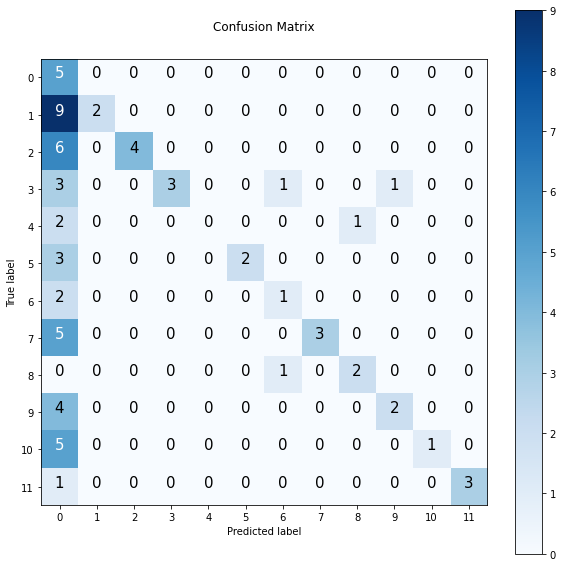

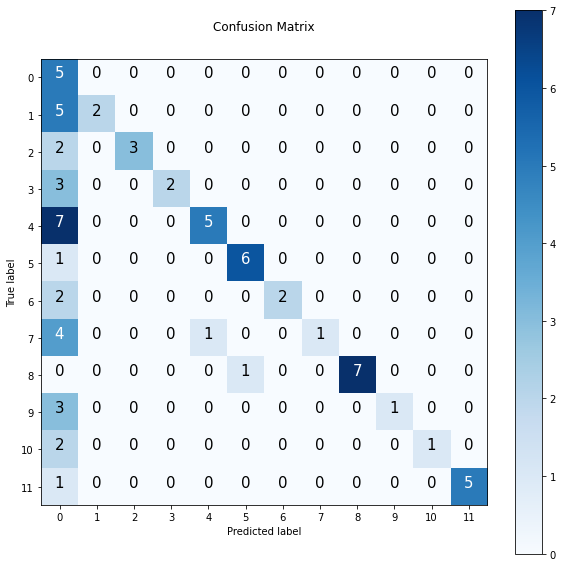

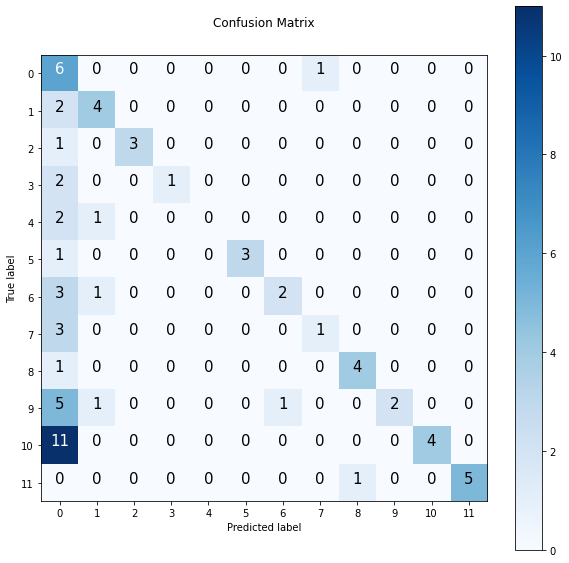

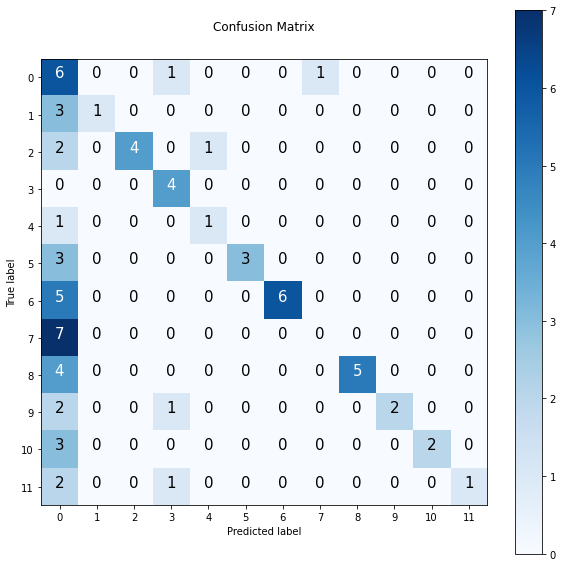

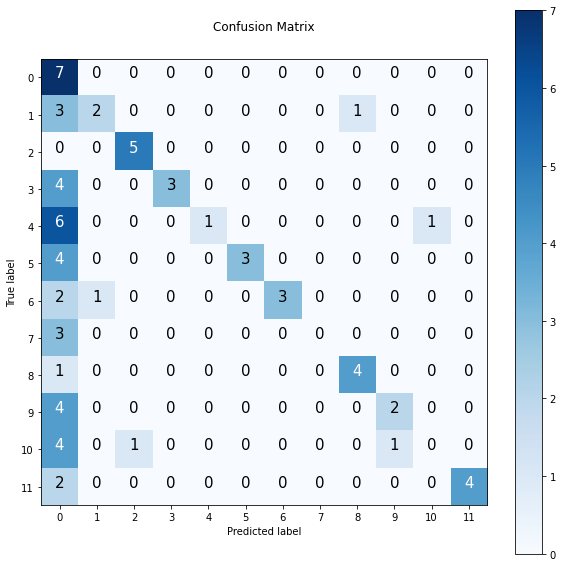

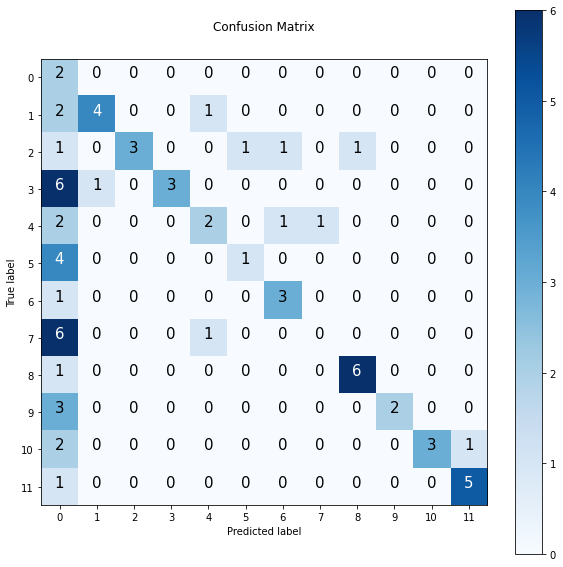

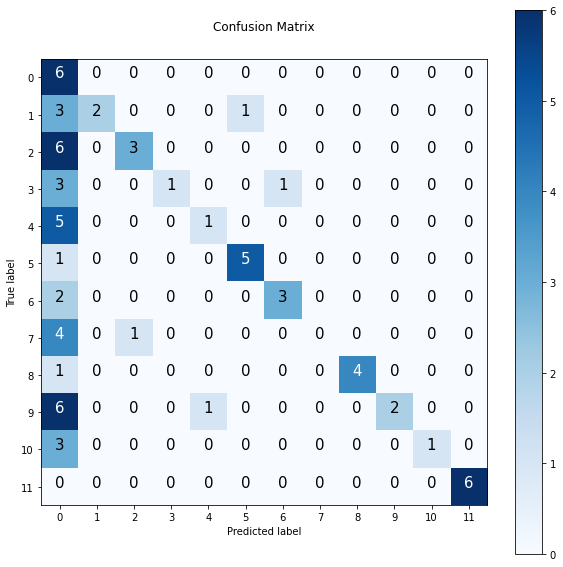

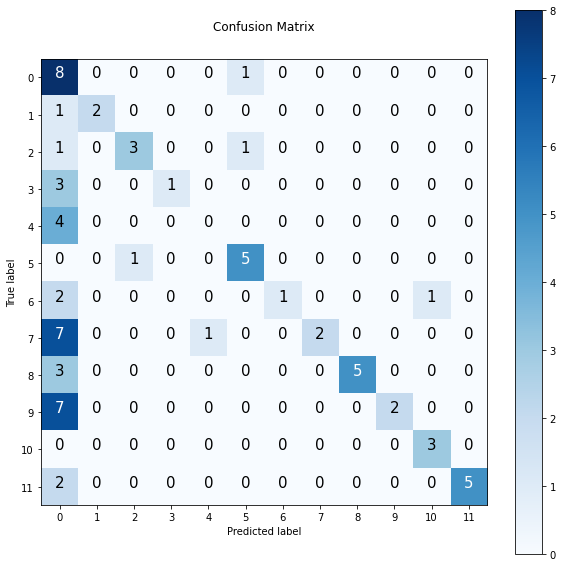

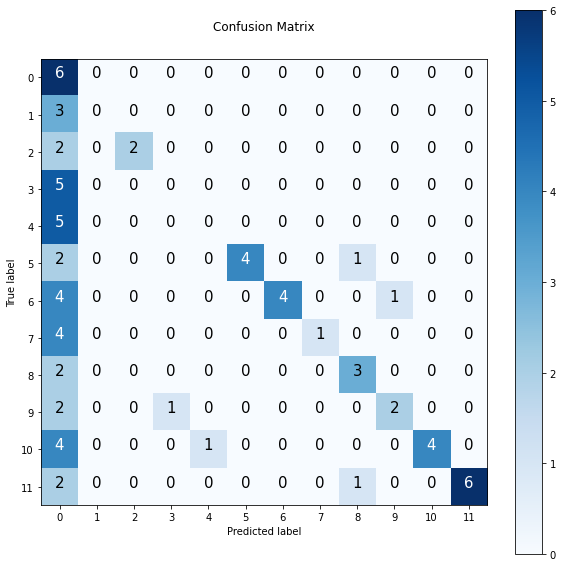

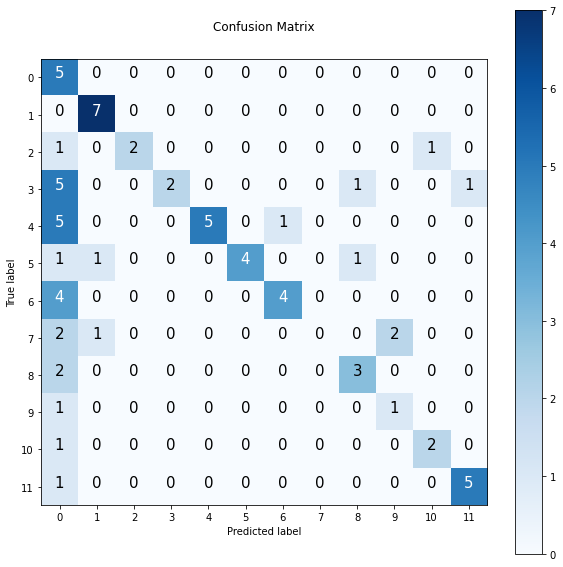

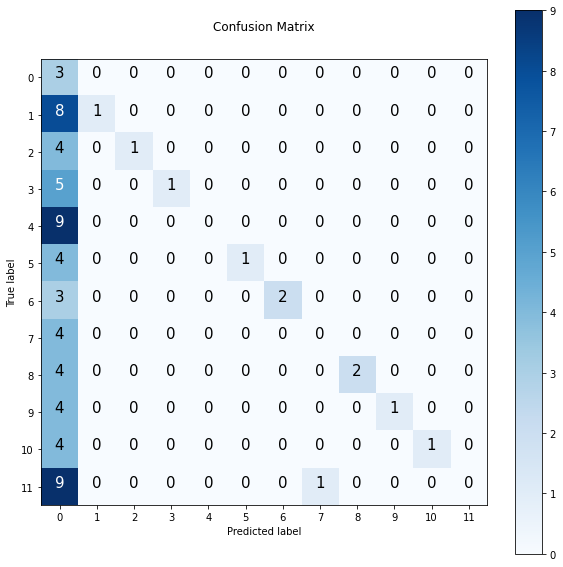

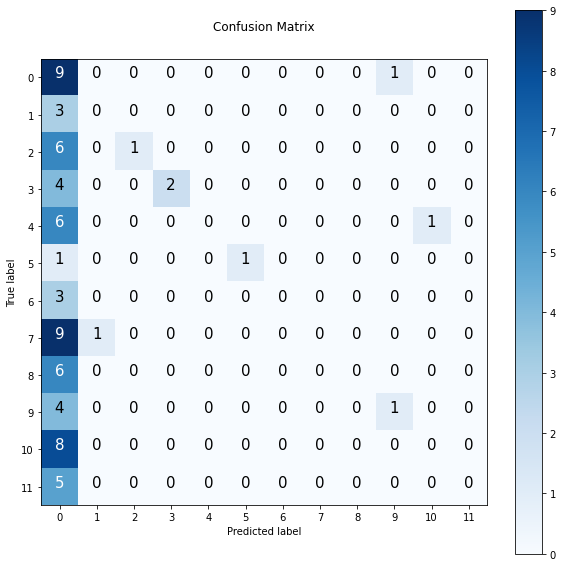

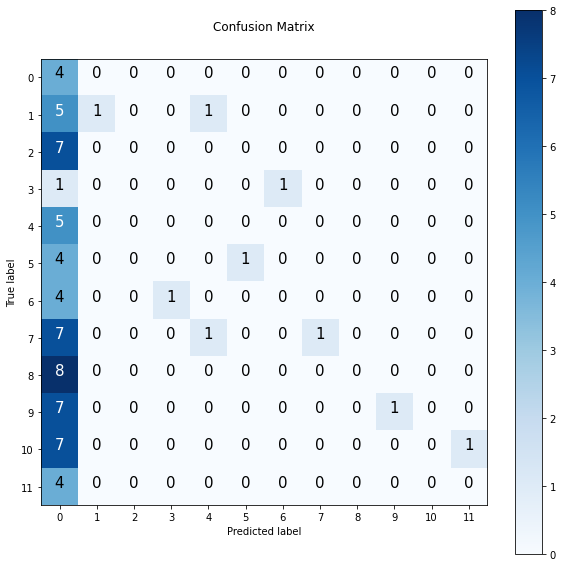

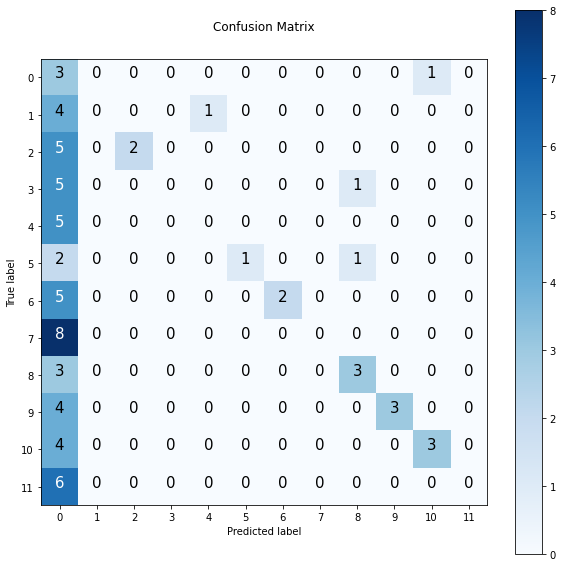

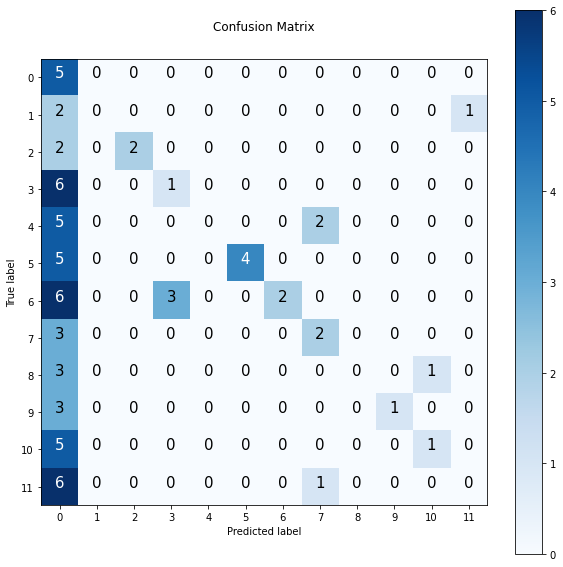

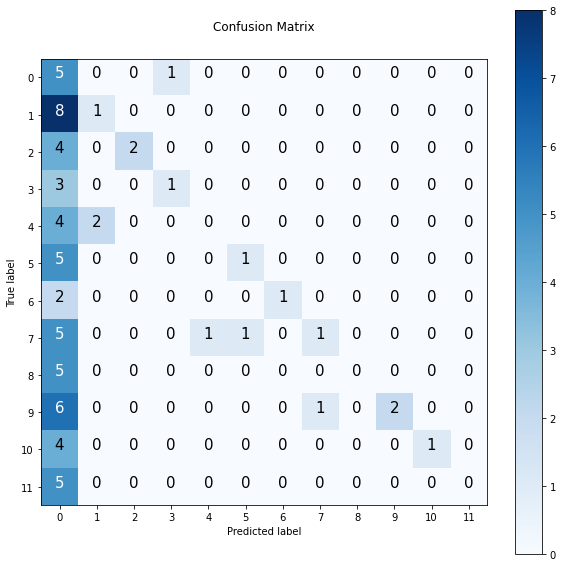

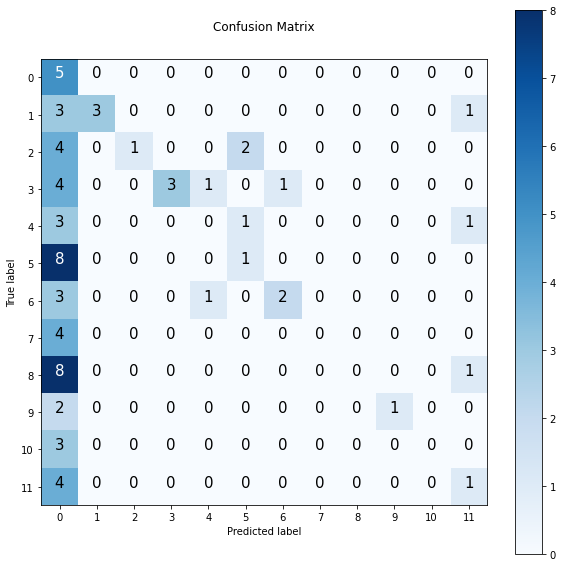

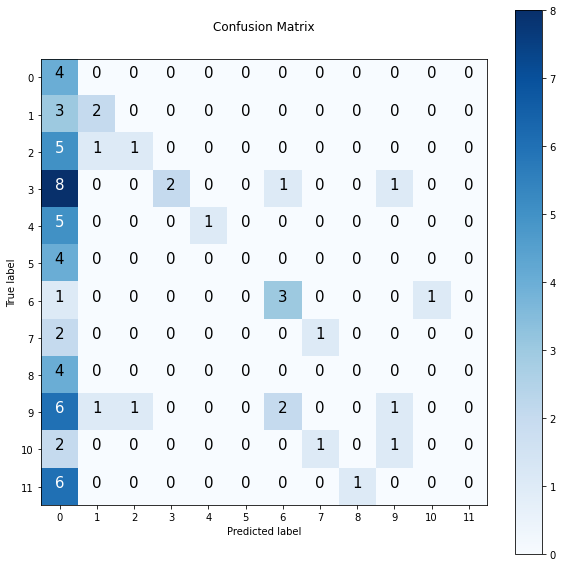

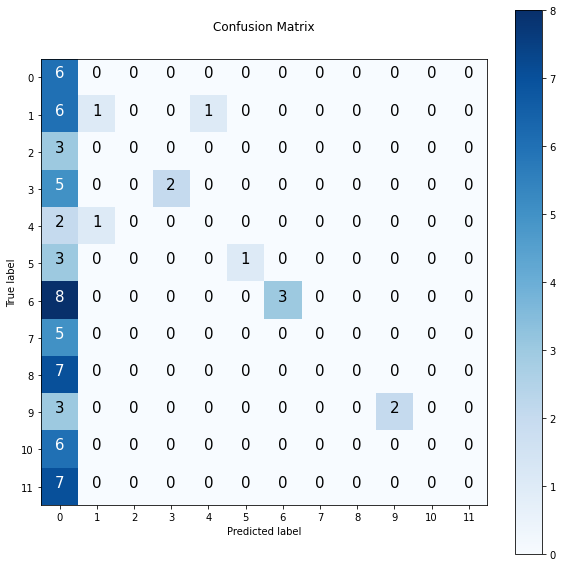

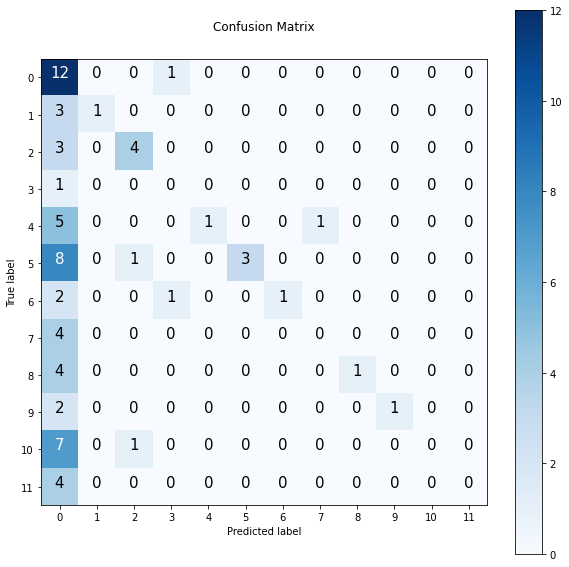

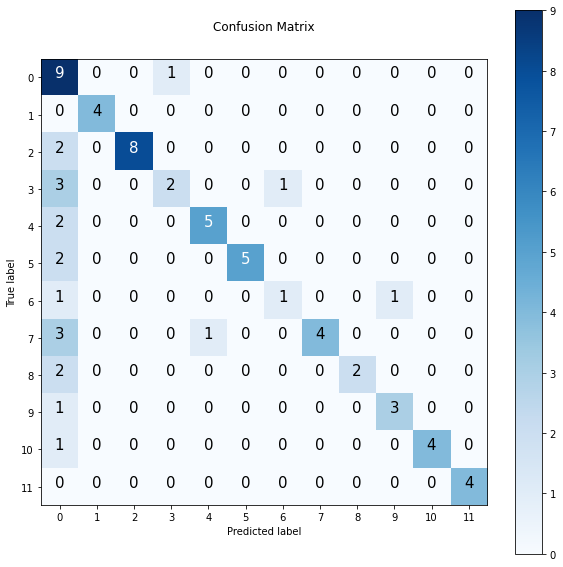

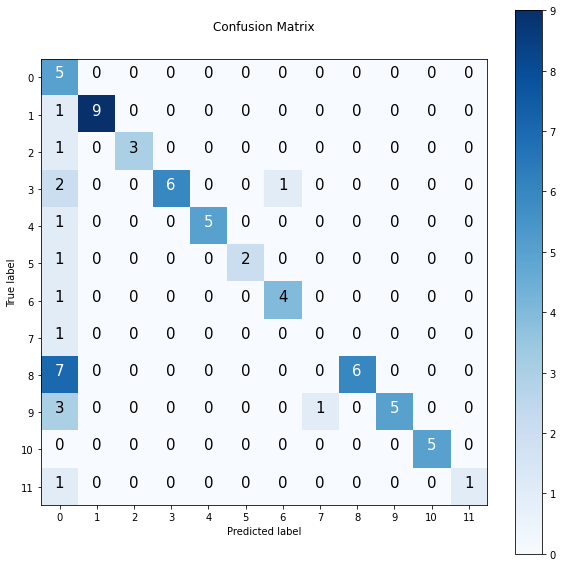

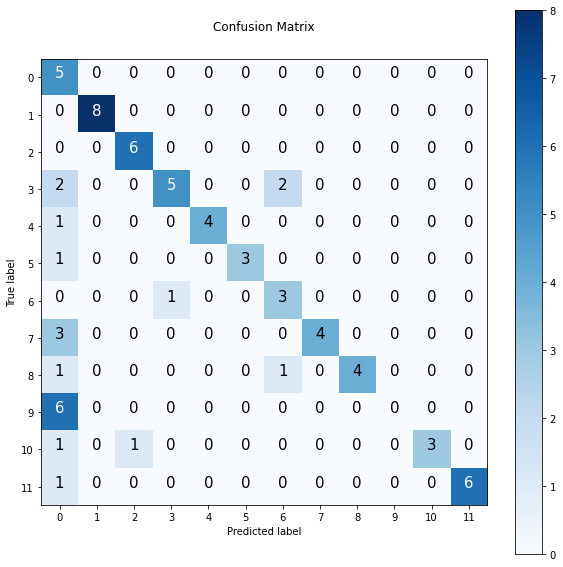

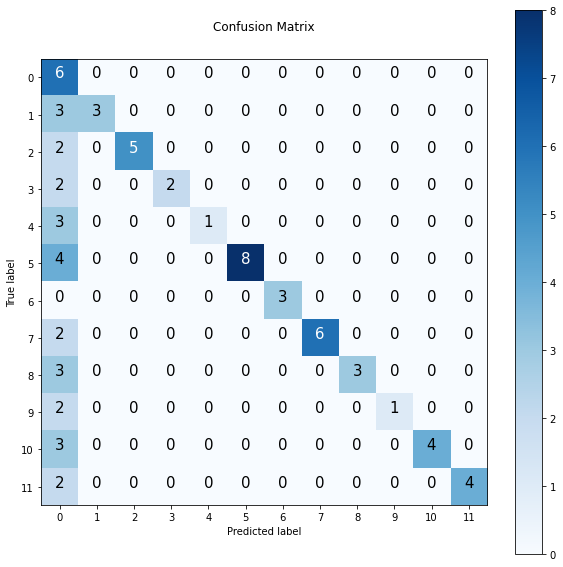

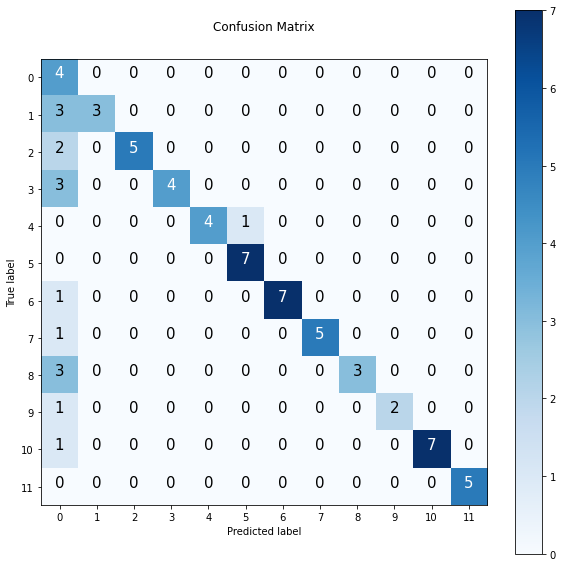

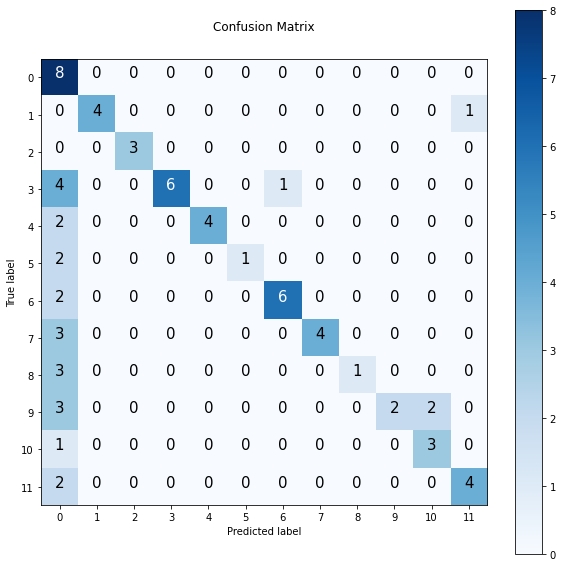

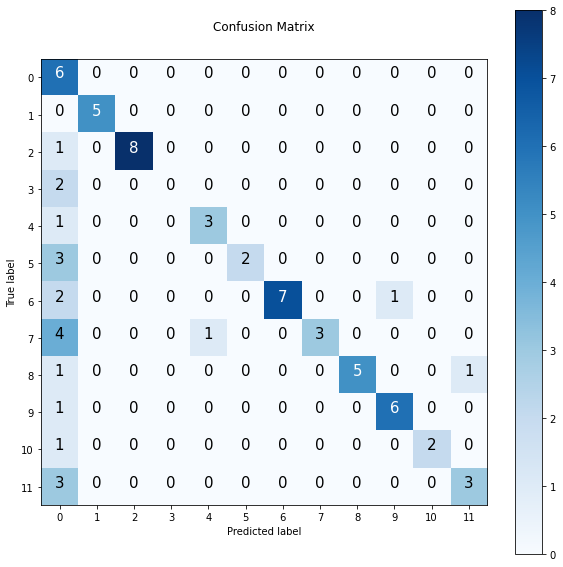

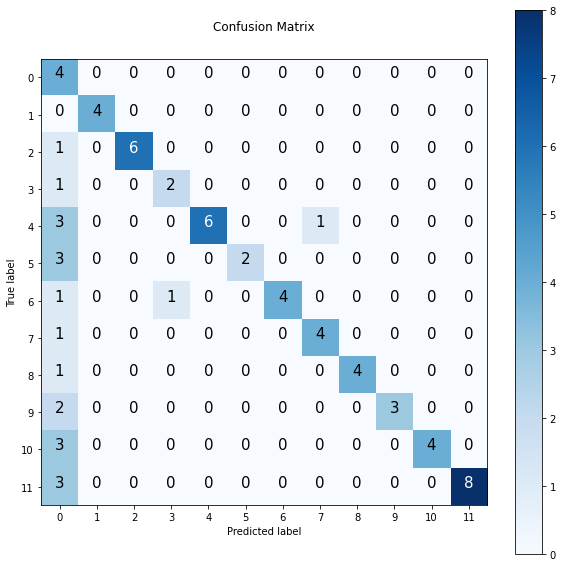

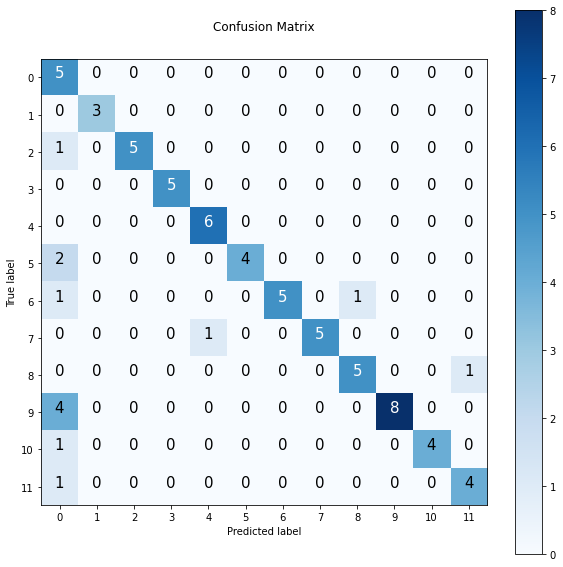

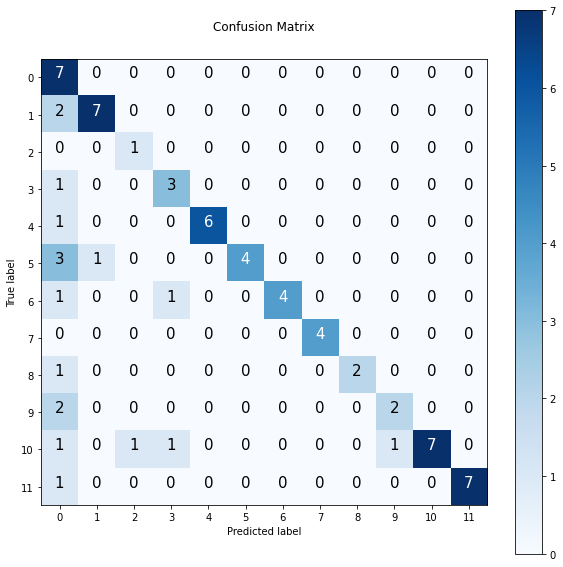

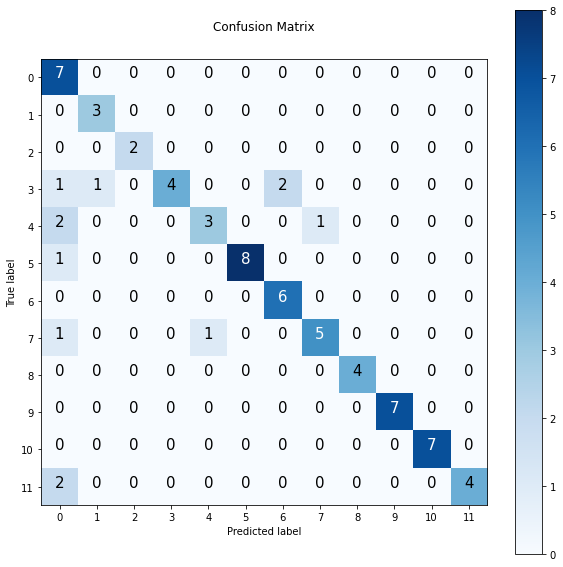

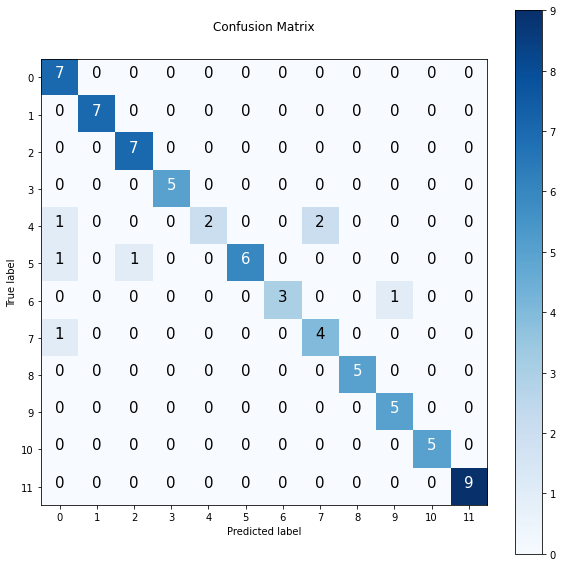

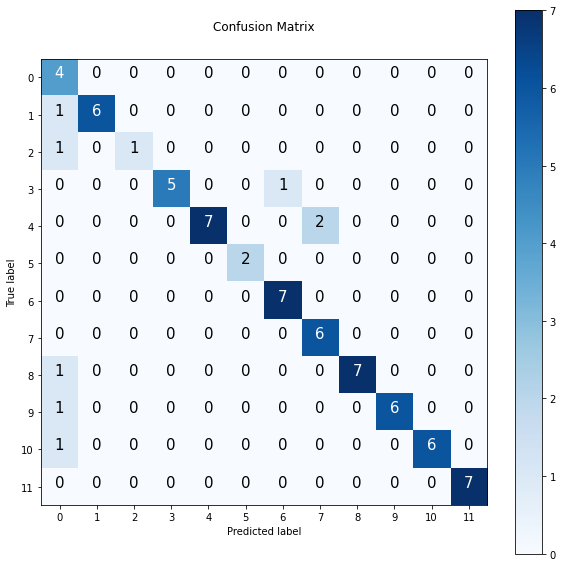

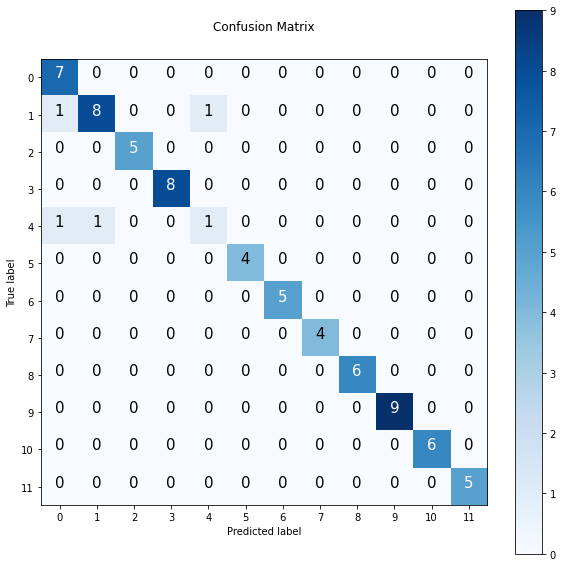

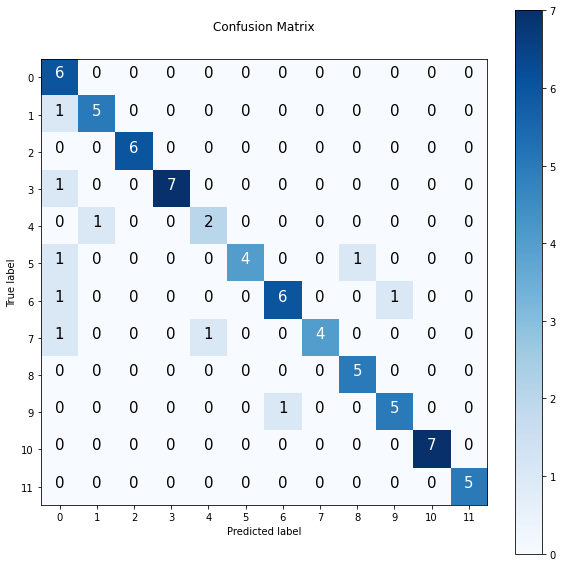

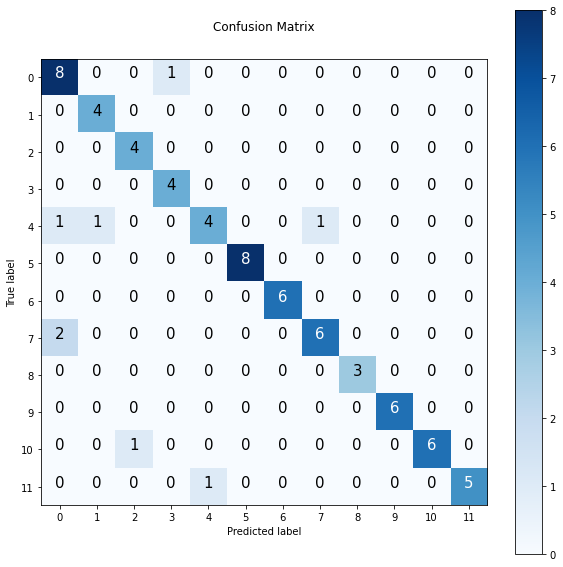

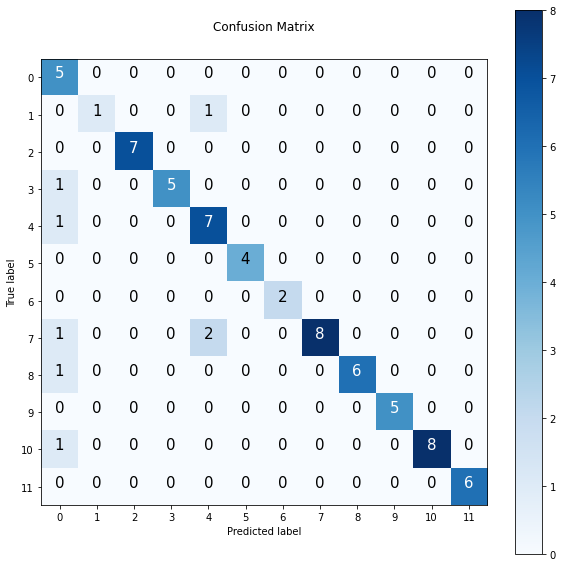

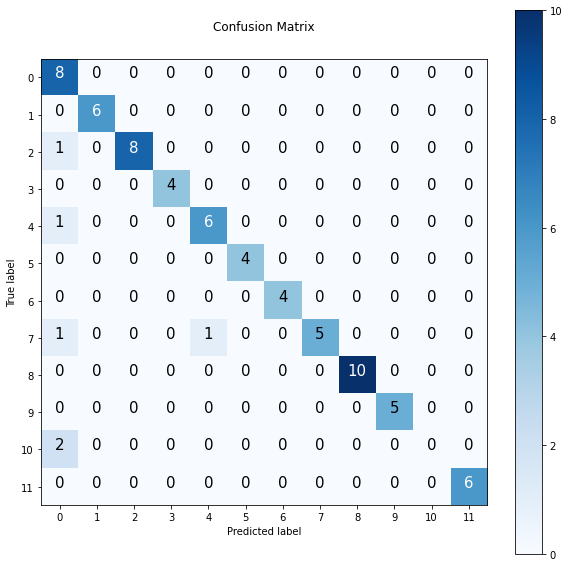

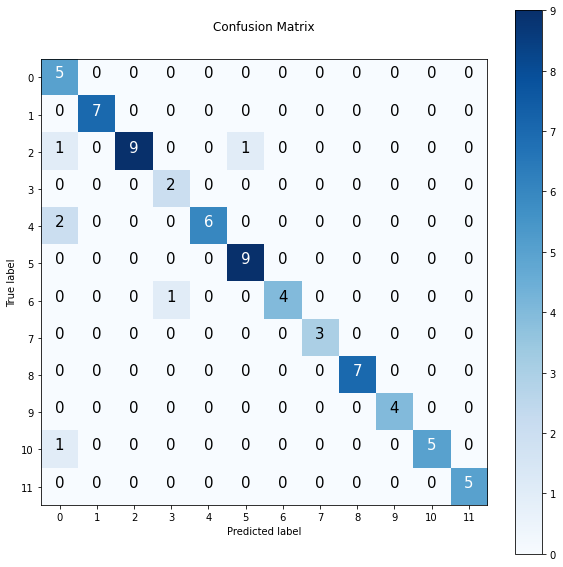

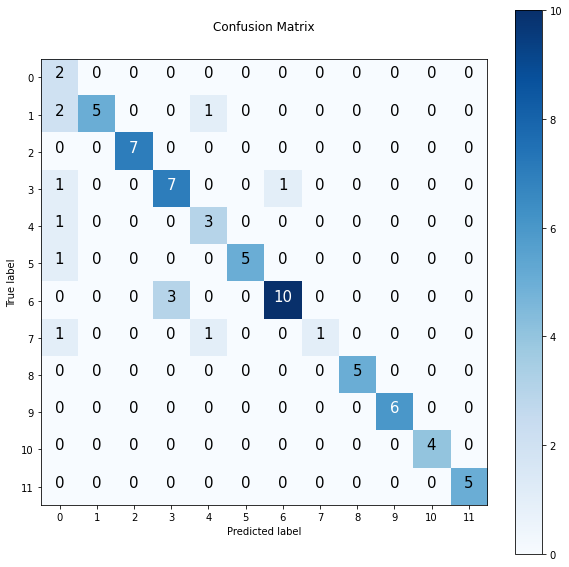

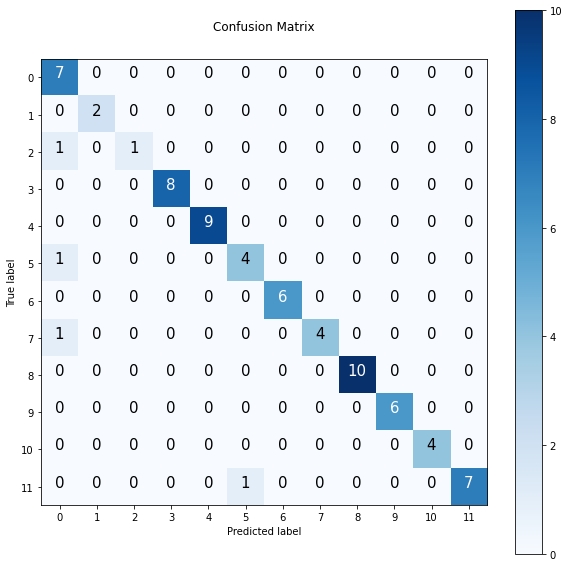

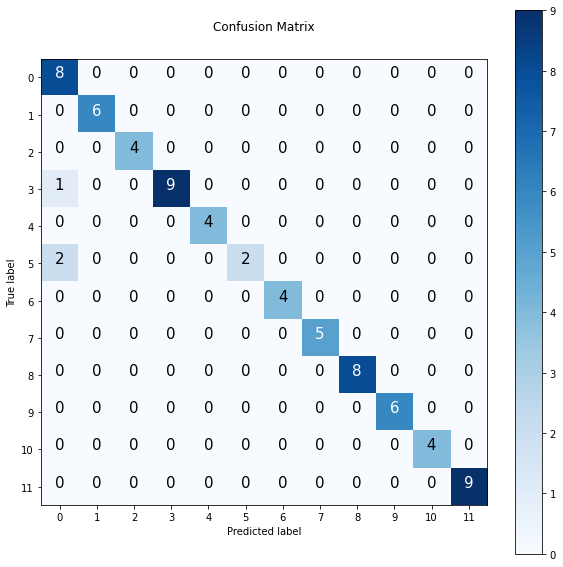

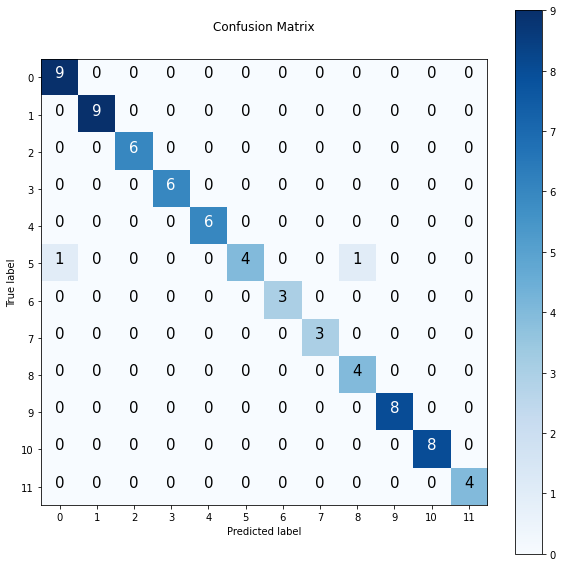

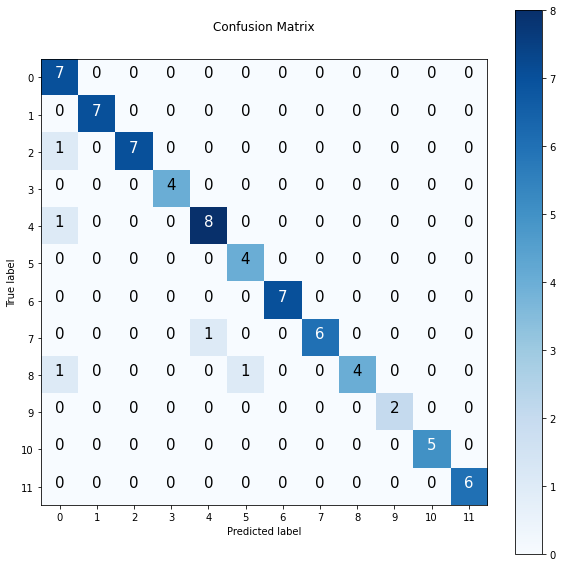

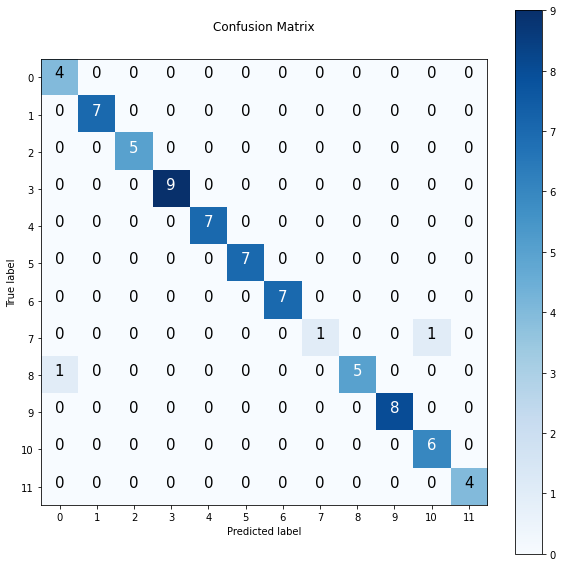

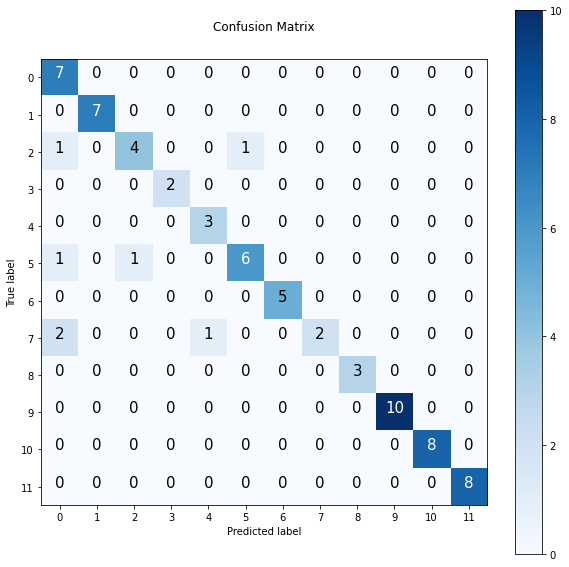

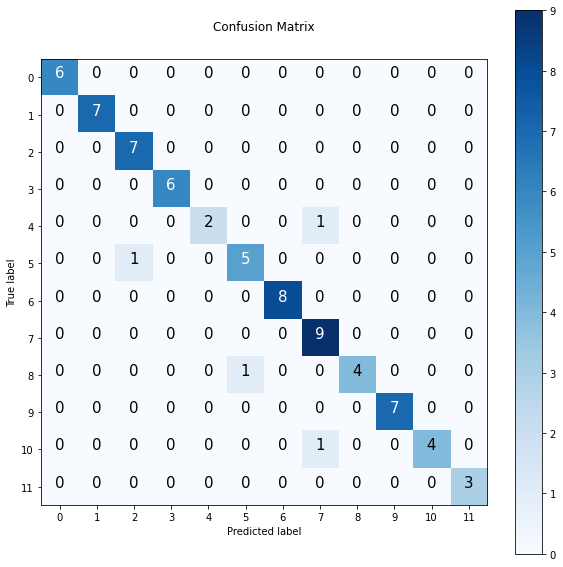

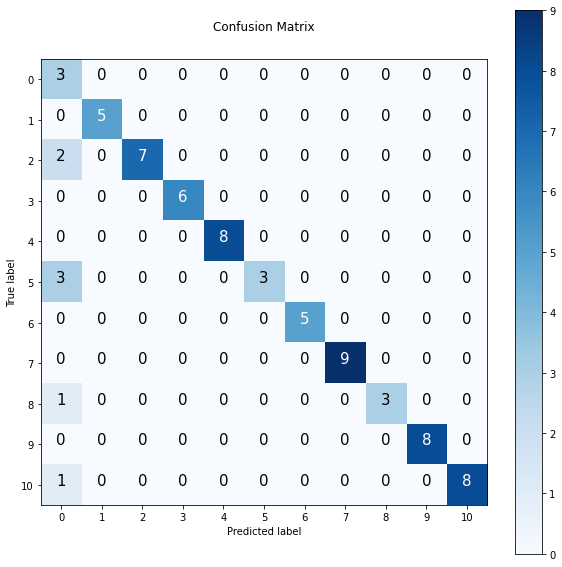

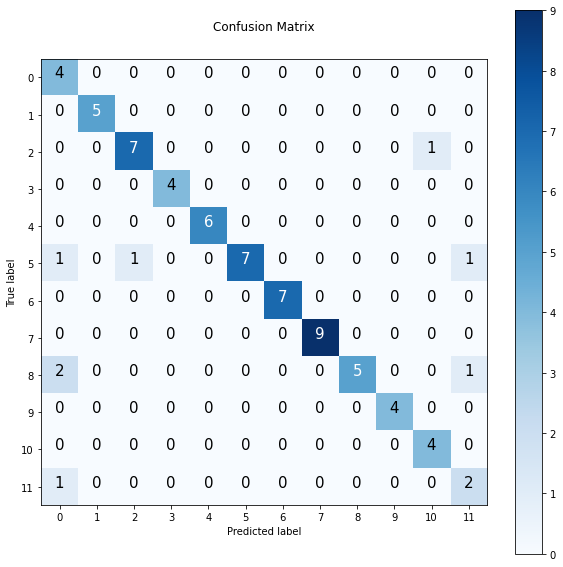

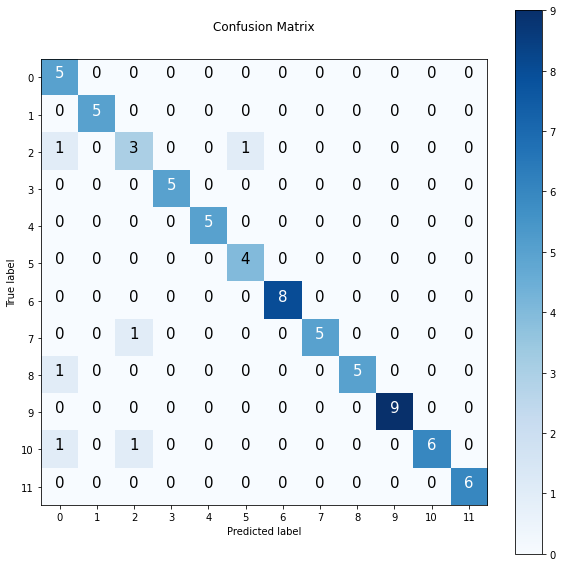

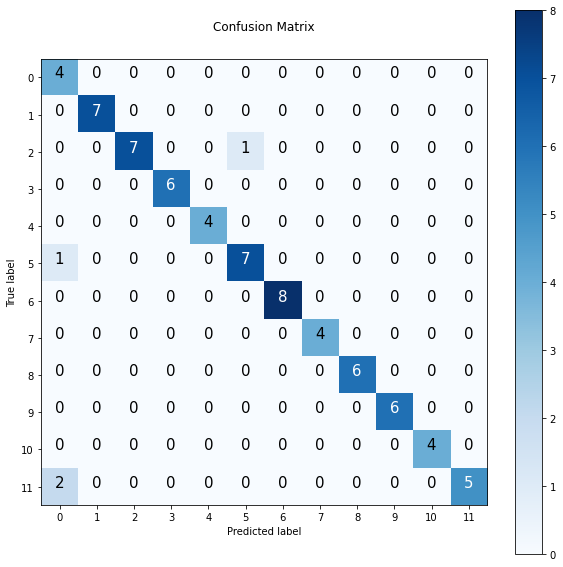

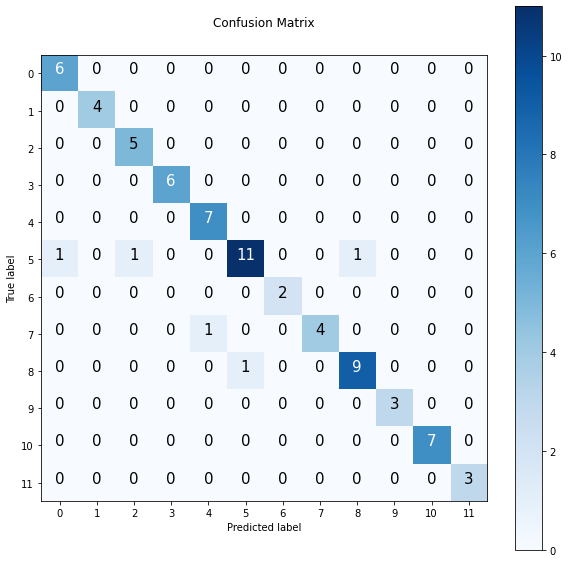

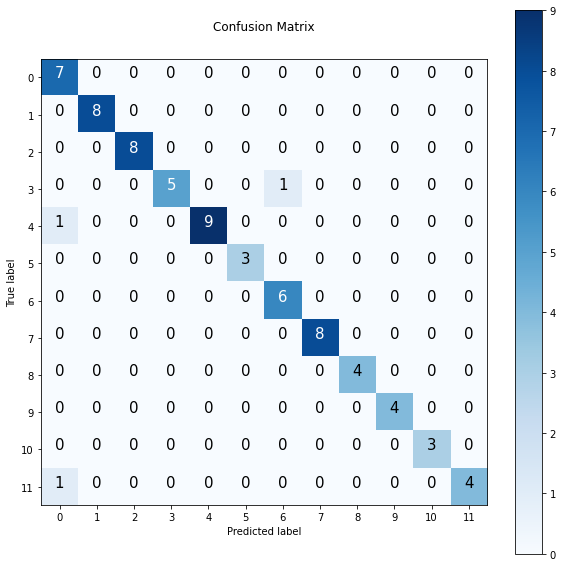

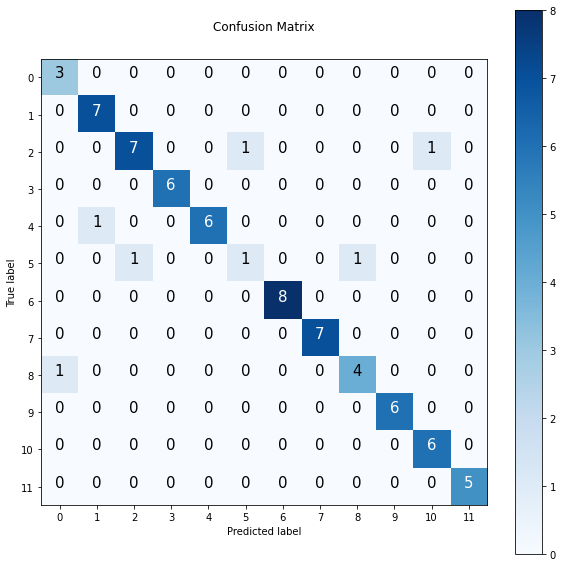

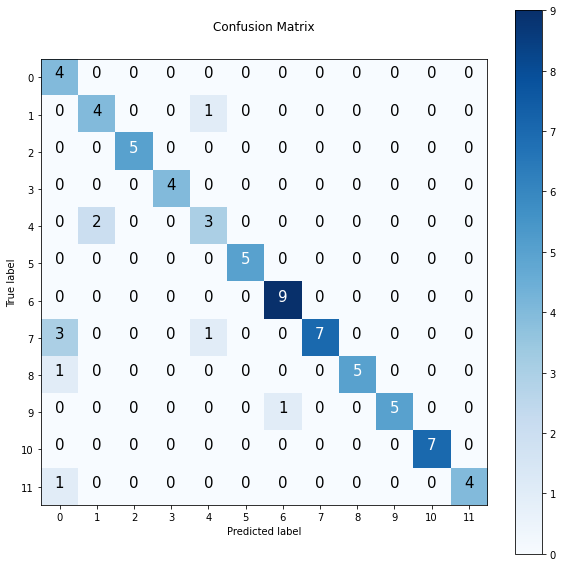

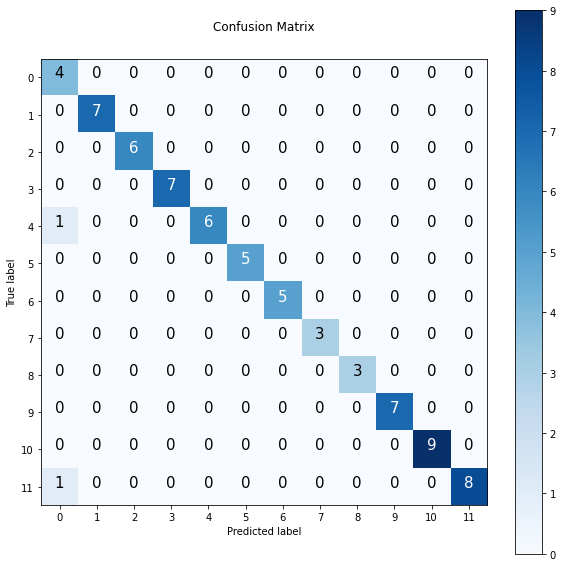

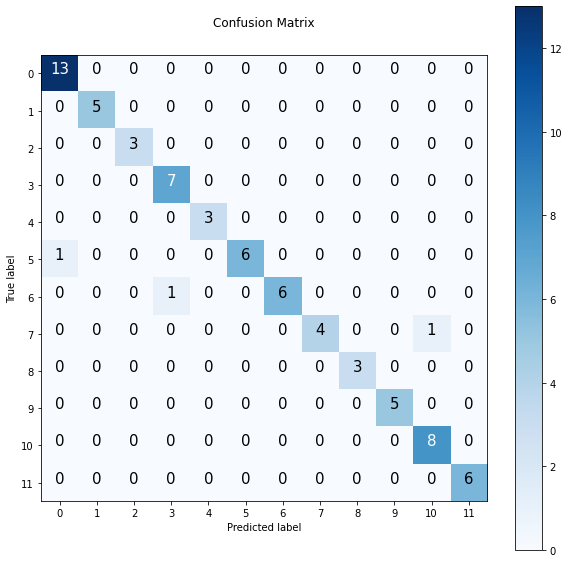

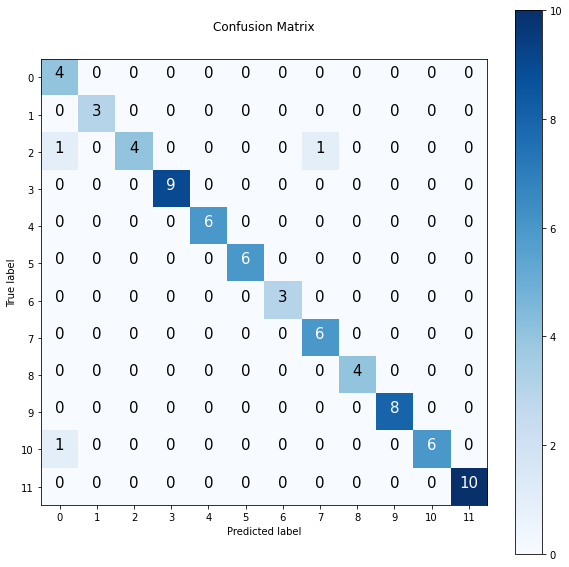

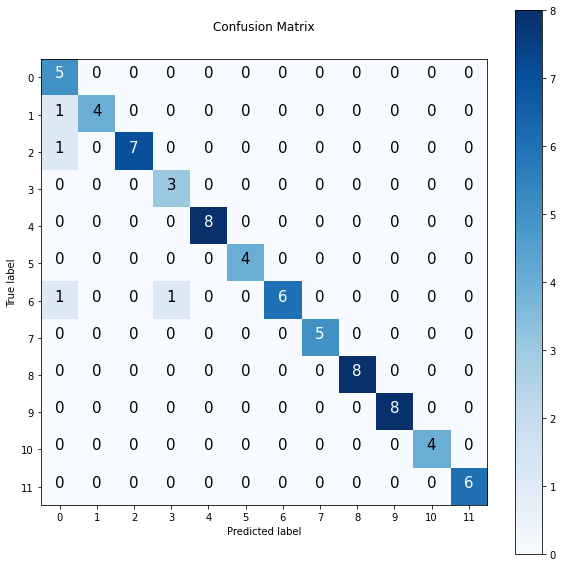

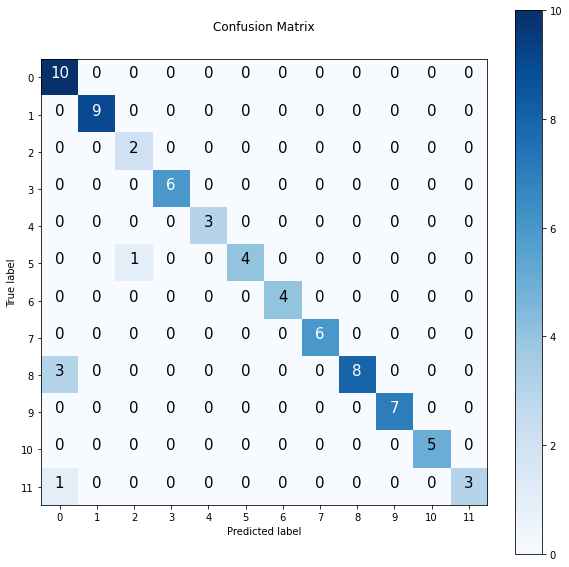

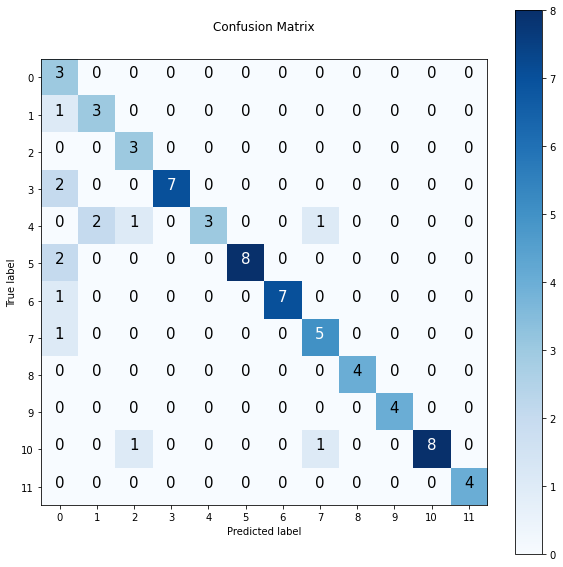

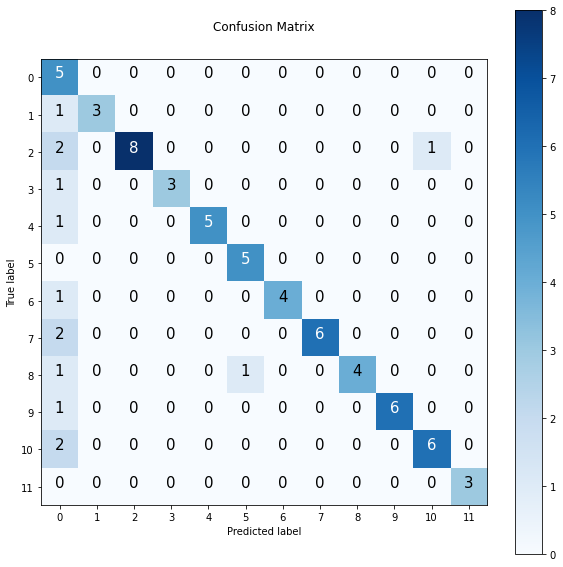

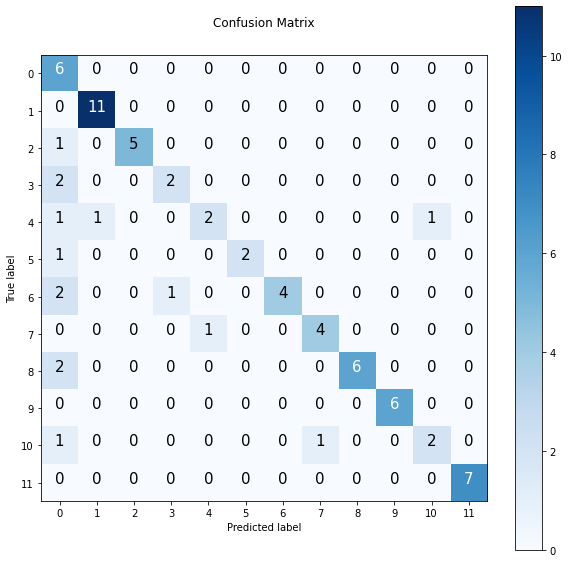

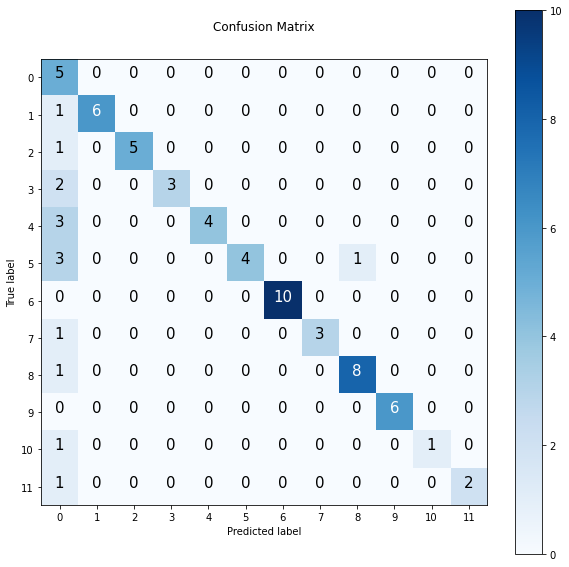

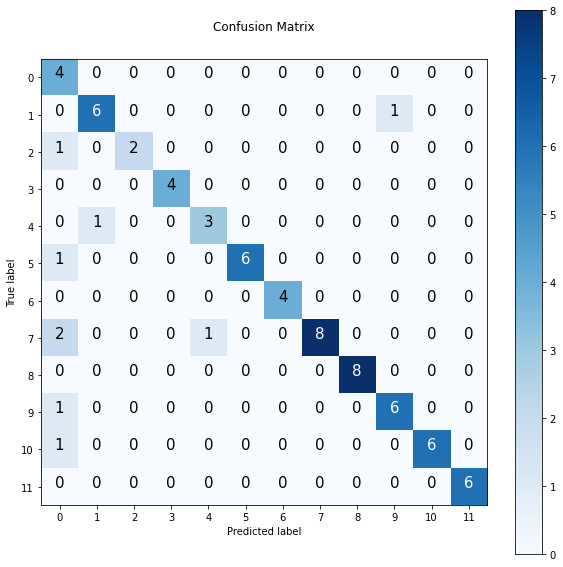

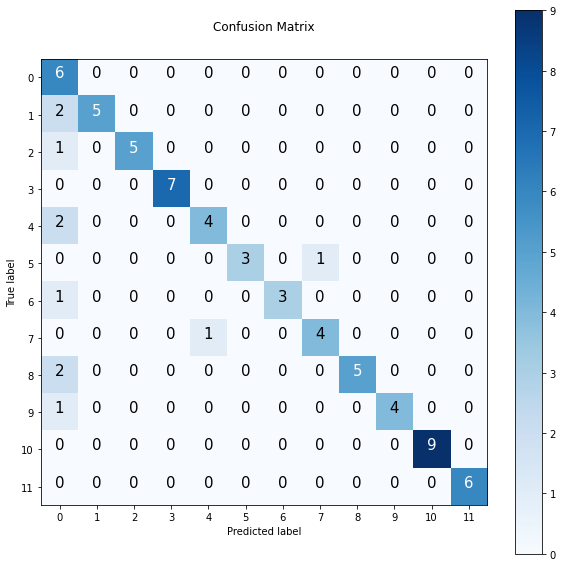

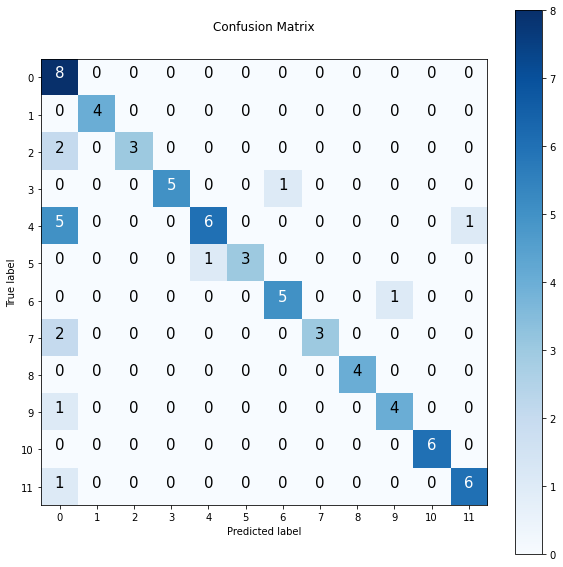

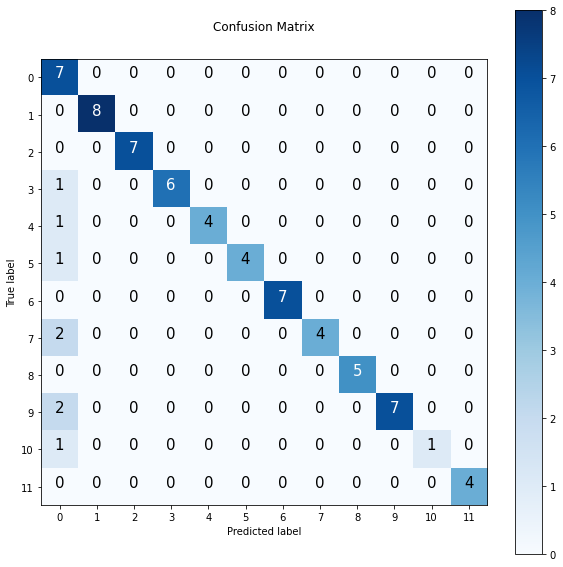

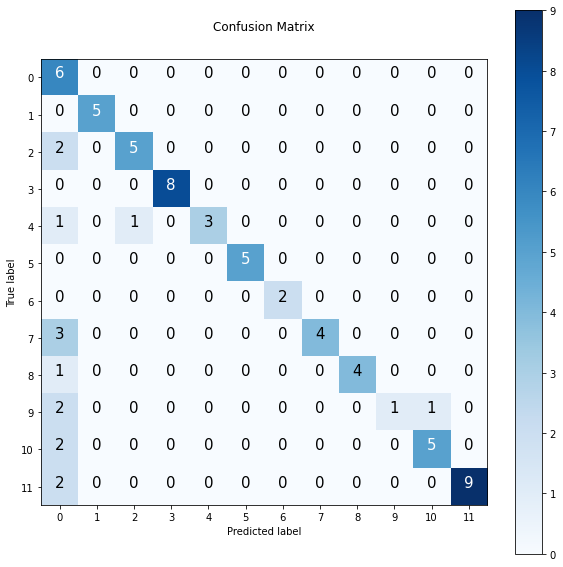

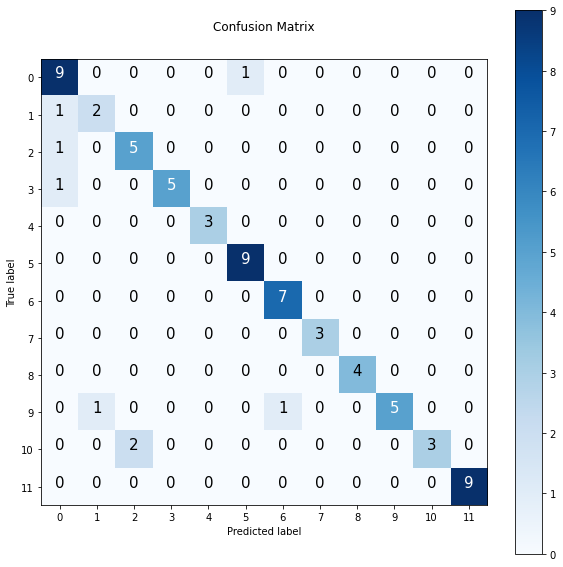

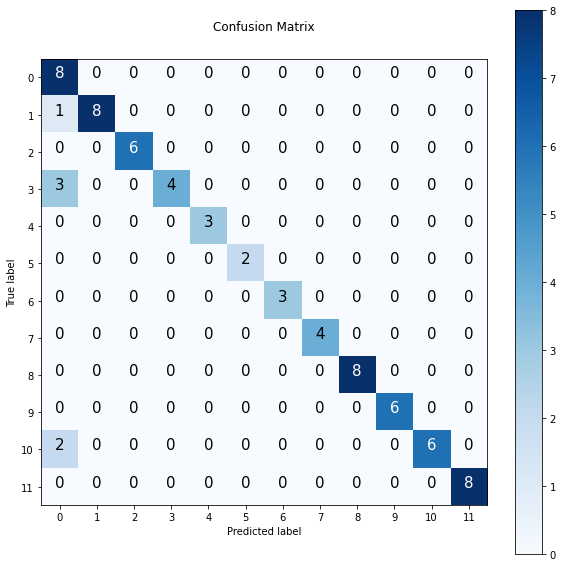

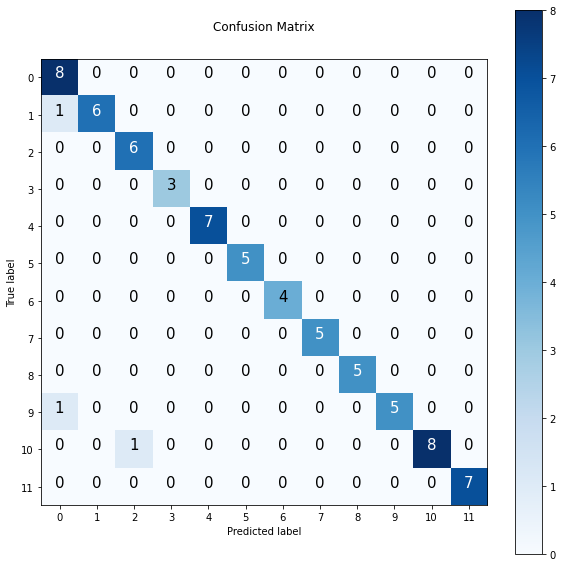

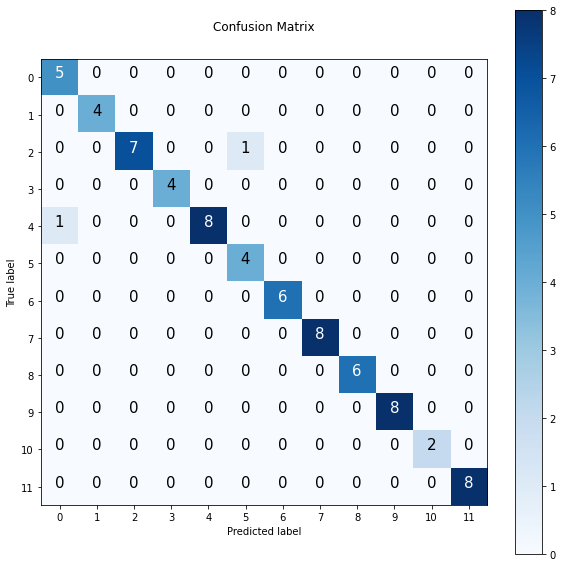

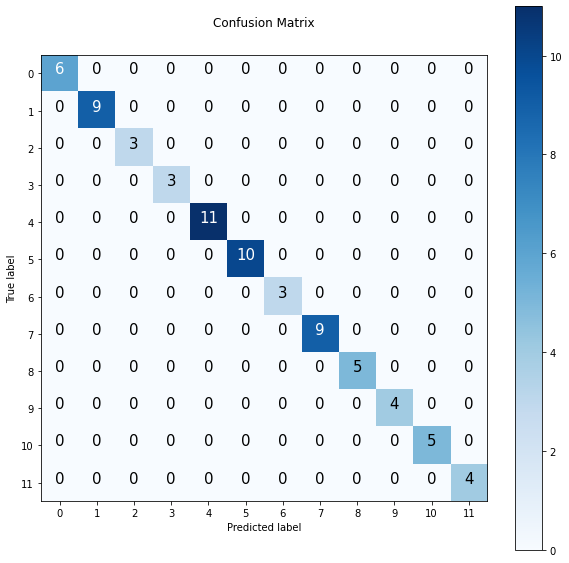

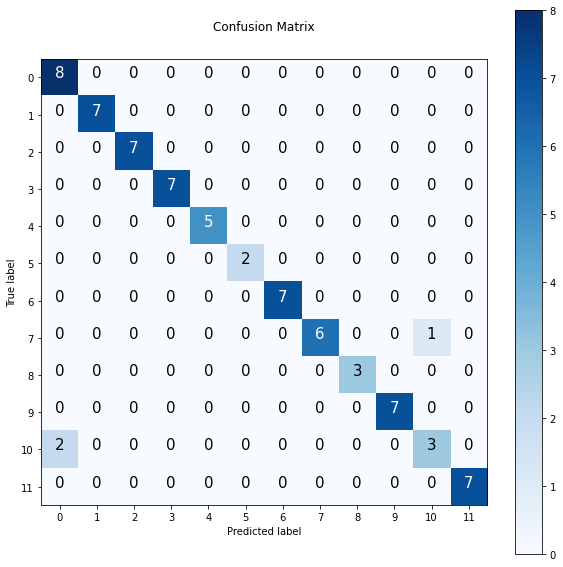

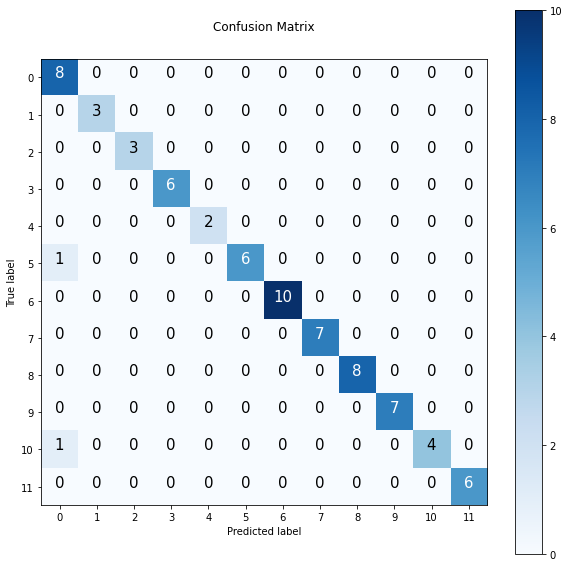

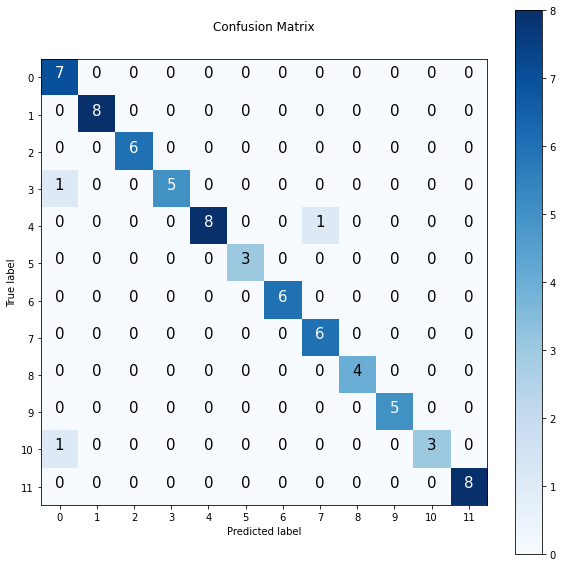

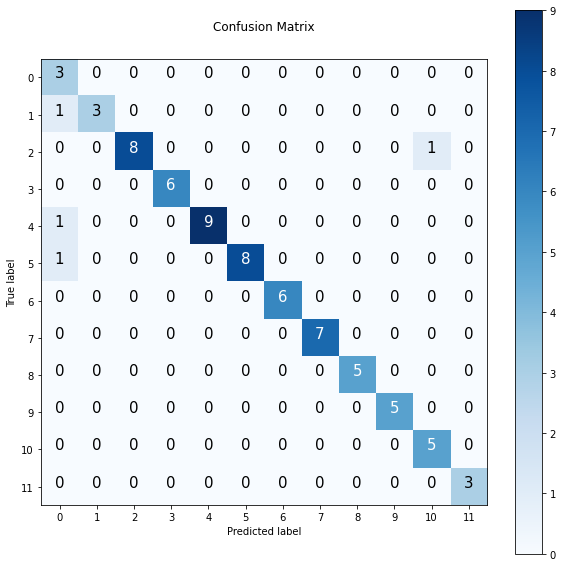

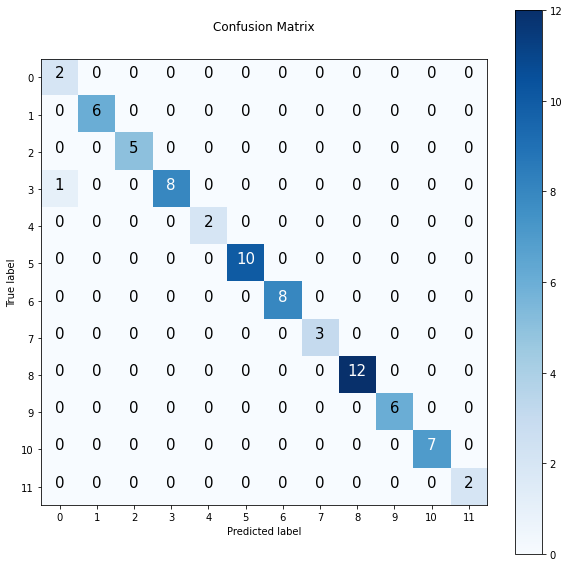

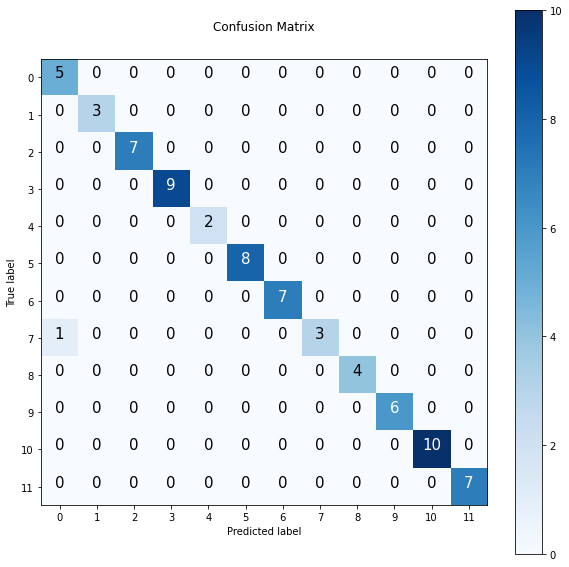

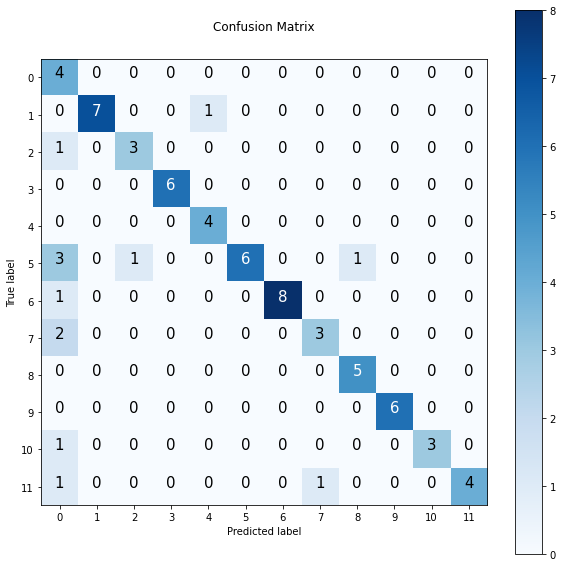

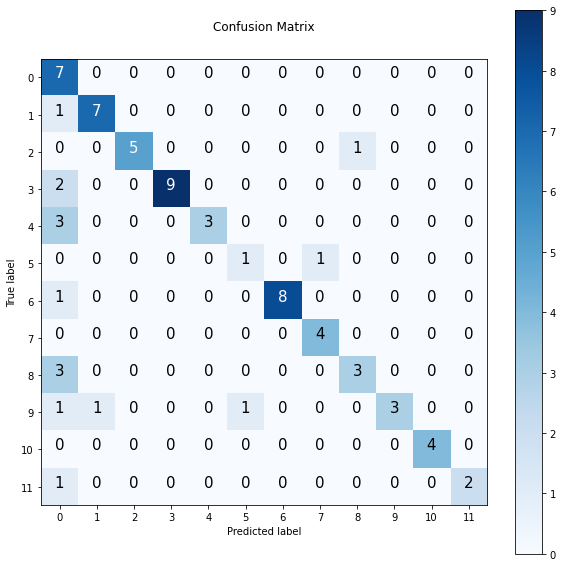

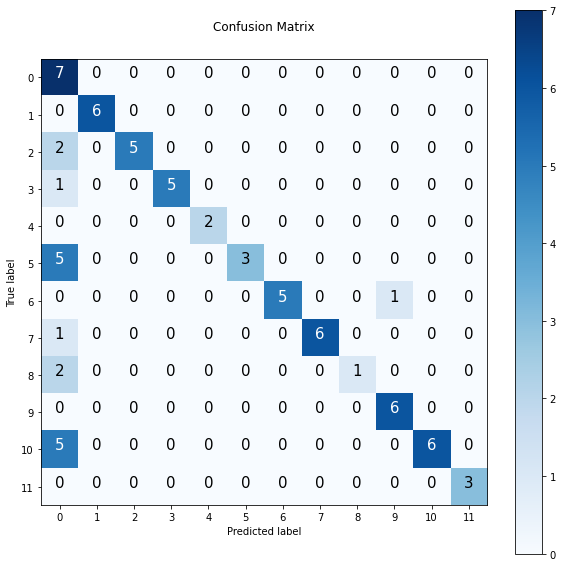

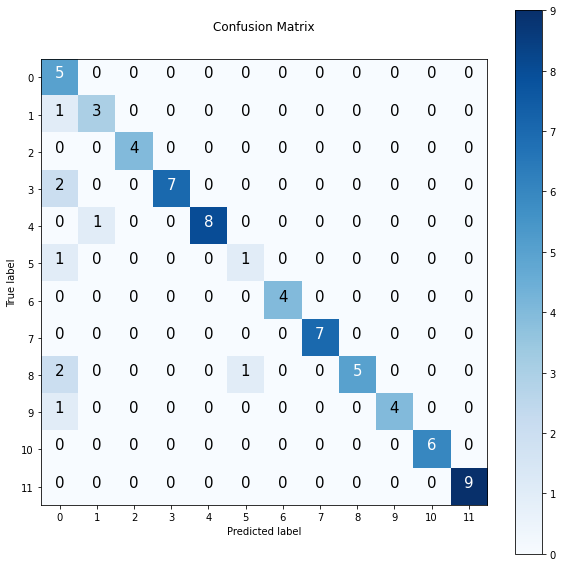

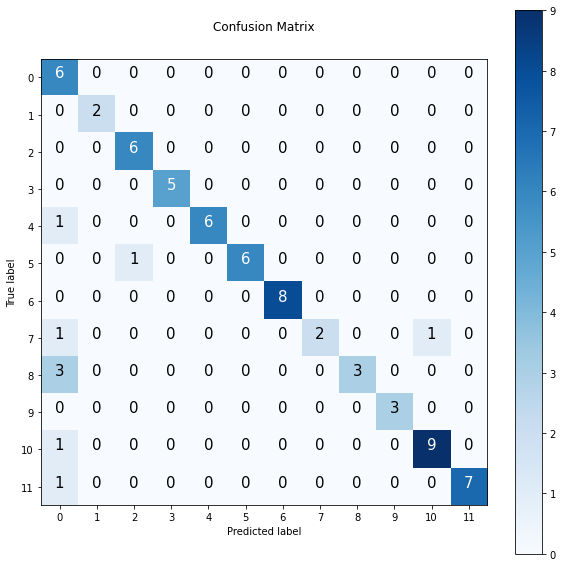

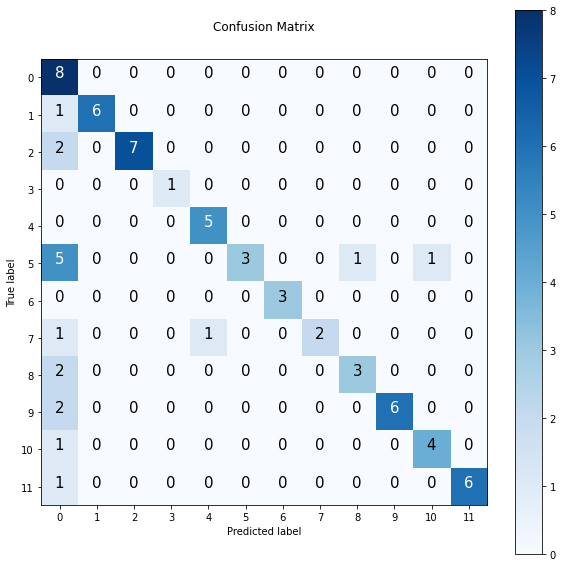

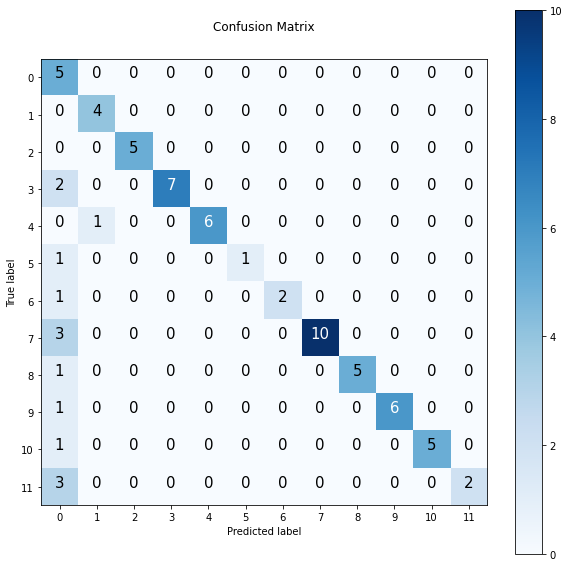

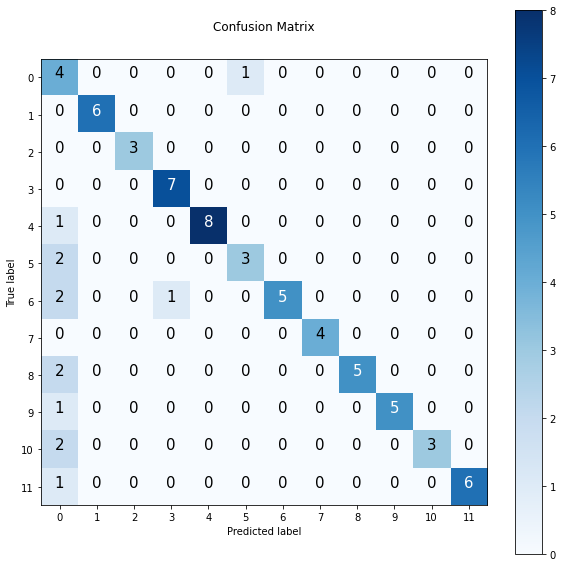

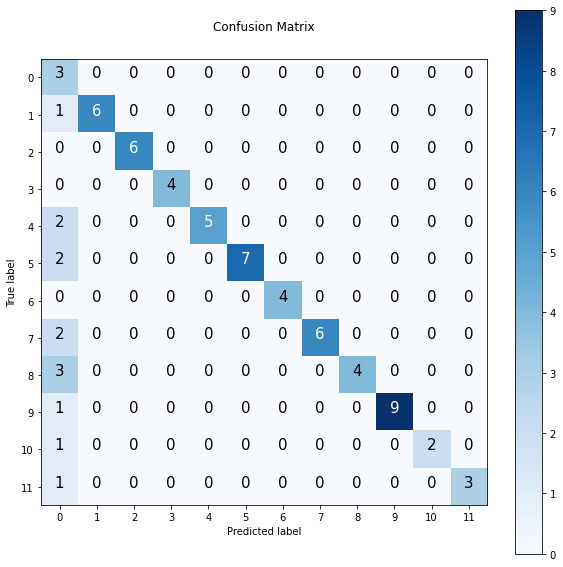

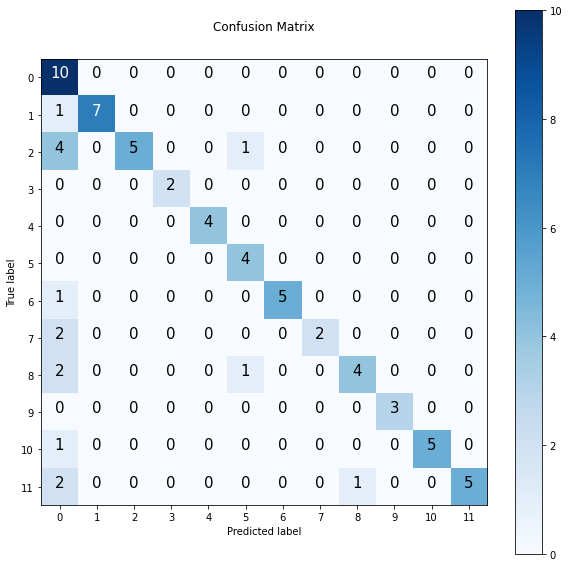

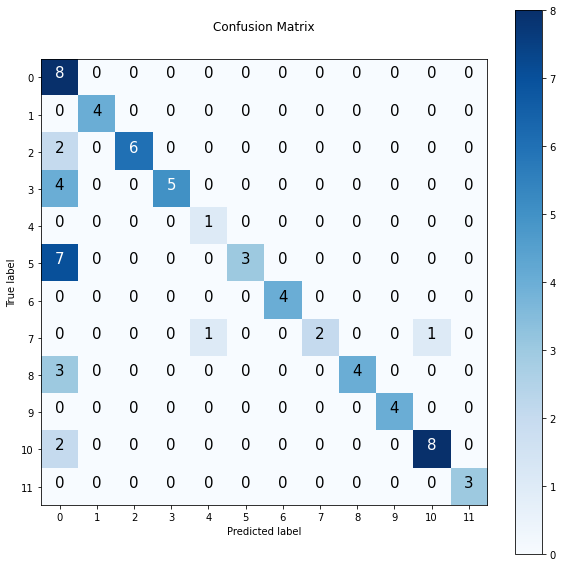

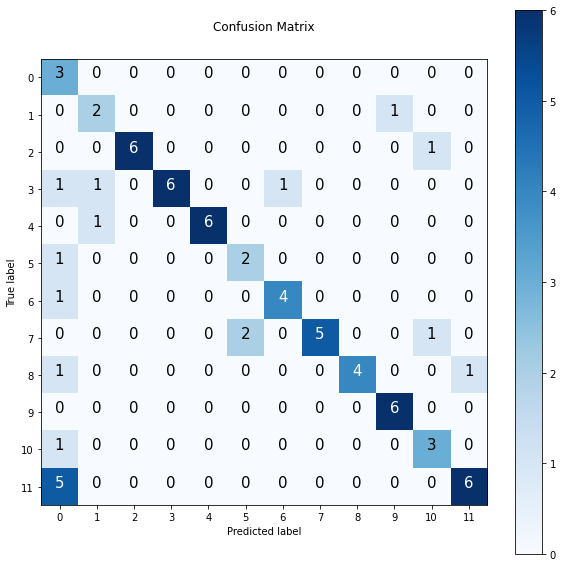

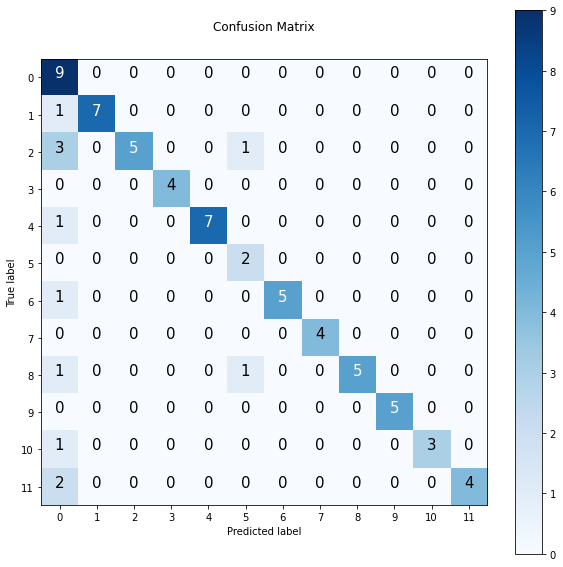

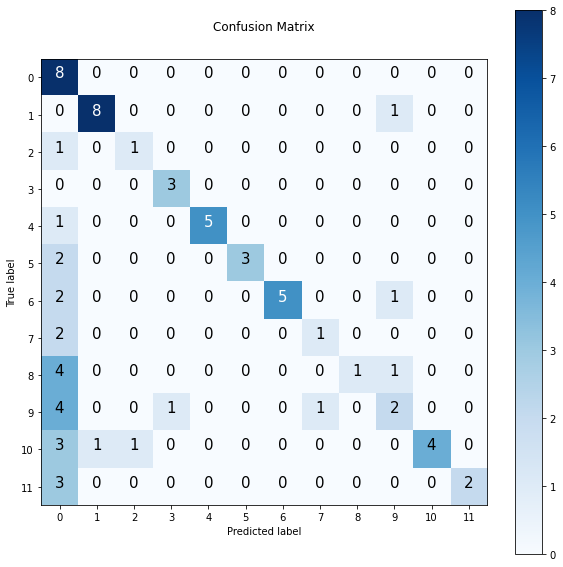

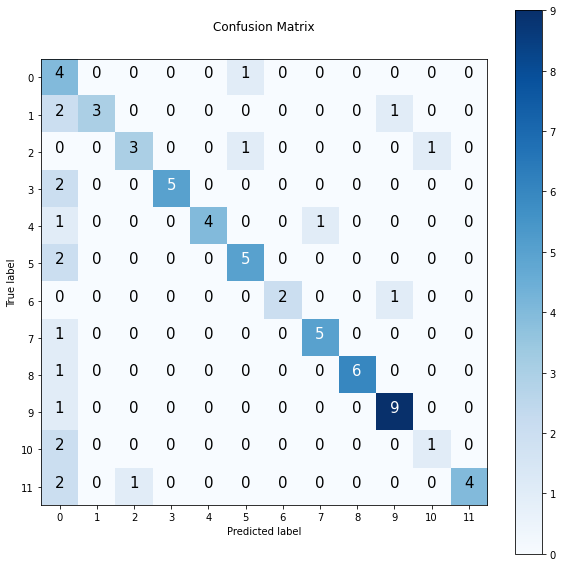

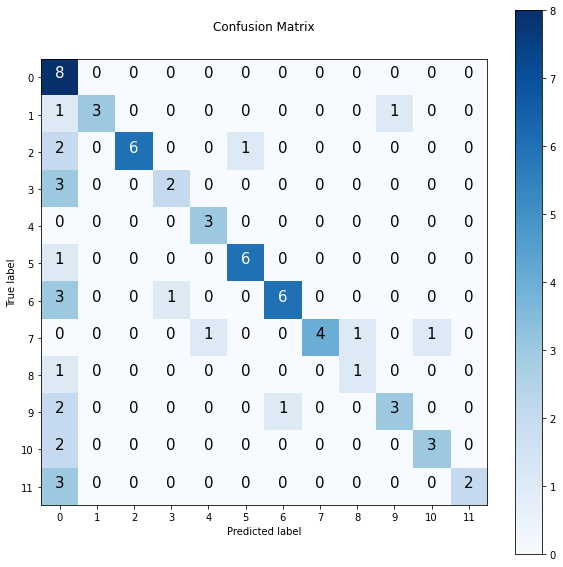

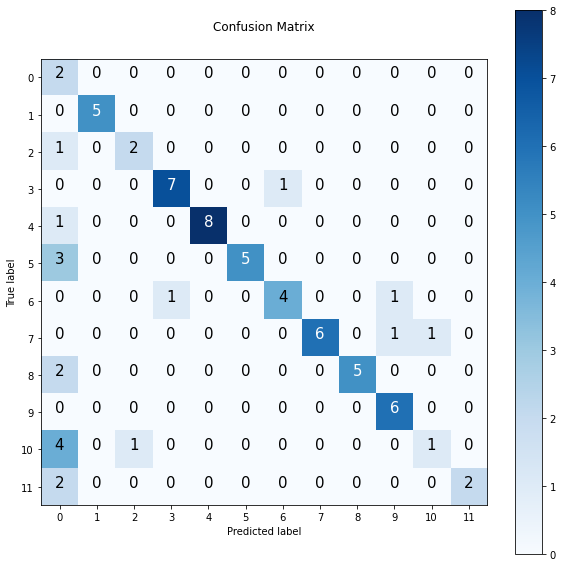

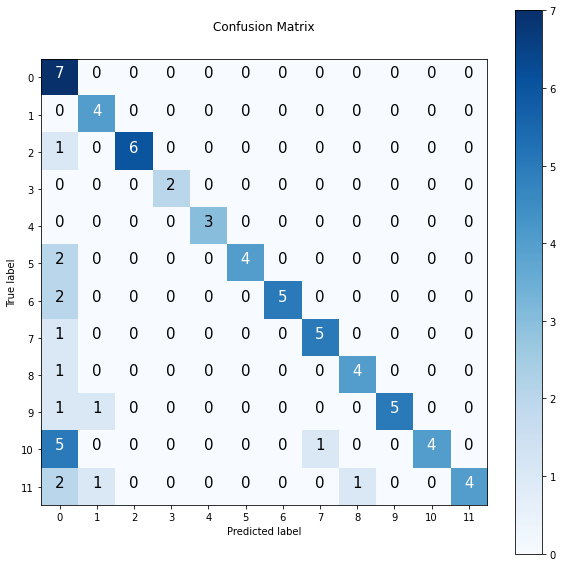

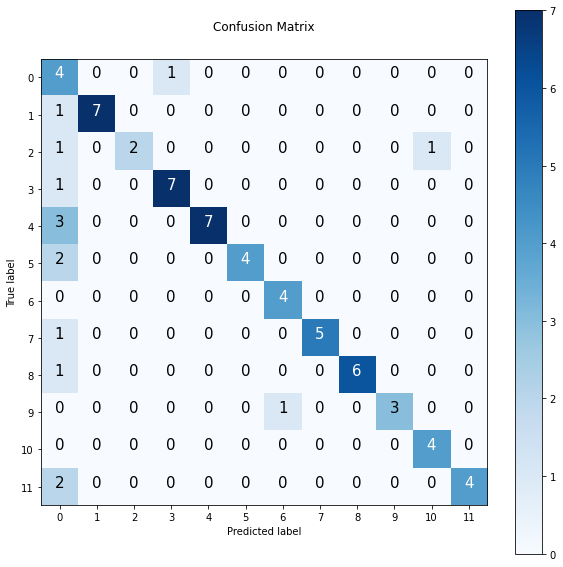

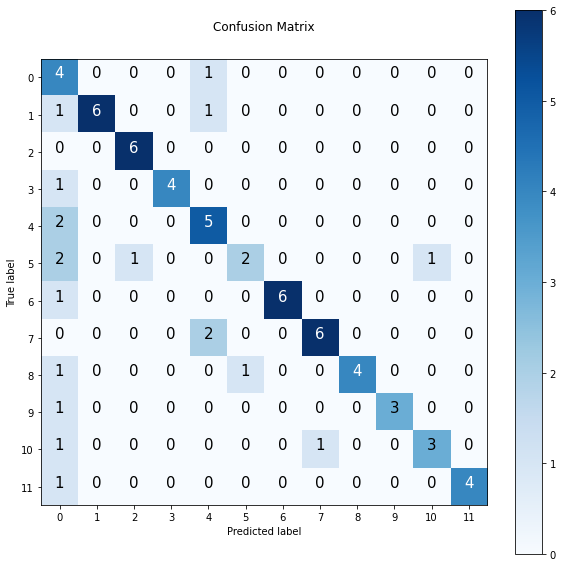

In [ ]:
for subject in mcnn_training_data.keys():
    print(f'\nMCNN - Subject: {subject}')
    train_data = mcnn_training_data[subject]['train_data']
    labels = mcnn_training_data[subject]['label']
    
    cv_acc, model = train_CNN_cross_val_predict(train_data, labels, 10)
    mcnn_results[subject] = np.mean(cv_acc)
    print(f'\nAccuracy: {mcnn_results[subject]:2f}%')
    

mcnn_overall_accuracy = np.mean(np.fromiter(mcnn_results.values(), dtype=float))    
print(f'Overall Accuracy MCNN - {mcnn_overall_accuracy:.2f}%')

In [ ]:
# change shape of data to match [batch_size, time_steps, n_features]
model.save('model.h5')

Now, finally train and evauate the model!

# Conclusions

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
model.predict()